In [1]:
pip install dython

Note: you may need to restart the kernel to use updated packages.


In [2]:
# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Correlation/Association strength metrics
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

# Assessment Criteria:
Testing your: 
- [ ] creativity
- [ ] analytics fundamentals
- [ ] technical knowledge
- [ ] communication
- [ ] connecting data to people/processes/business outcomes

1. How I create insights
2. How I communicate insights
3. Questions I ask Kevin/stakeholders before heading into analysis

# Problem:

* Interested in understanding how frequently we deliver to our customers on time, vs. how frequently we are late.
* What factors contribute to our on-time delivery (OTD) rates.
* And how we can do better at delivering on time? 
* Also interested to know what other insights you can derive from this data (not necessarily related to OTD rates).

## Context around Problem:
    
* Why is this problem being investigated:

At times, Welocalize has put a lot of focus/effort onto <font color='red'>client retention and satisfaction</font>. And we've heard from clients that <font color='red'>worse-than-expected on-time delivery rates</font> is one of the biggest things that makes them dissatisfied.

* Company threshold for what is an alarming rate of tardy deliverables:

It varies by customer and by program, but the great majority of customers expect <font color='red'>90-95%</font> of deliverables to be delivered on time.

* What would be considered an improvement?

Meeting customers' expectations.

* What time interval are we measuring punctual/late deliveries (per month/per week)?

Again, it can vary; some high-volume customers/programs might look at it daily. But probably the most typical way to look at it is <font color='red'>by month</font>.


* Reason for heavy sparseness of data in column -average_duration_request_received_to_quoted_business_seconds:

Some projects are not quoted, because we have a <font color='red'>long-term contract with the client that allows us to skip the quoting process</font>, and start work on all their requests/projects immediately, without any quote (and quote approval) process. If there is no quote for a given project, then there is no duration here.

*  A request has a number of deliverables. And a deliverable has a number of tasks, which can consist of one/couple of translation tasks?

A <font color='red'>deliverable typically has a series of tasks that are required</font>, to do all the translation/localization. For example: technical tasks to prepare the source file(s). Initial translation. Review of the initial translation by a second linguist. Technical tasks to prepare the output file(s). Delivery tasks.

But the exact set of tasks varies by client, but content specialty, and more.


*  And for Welocalize, a supplier is a task owner which can be a translation worker?

Yes. Certainly the translation tasks are done by workers who are linguists/translators. Other types of tasks can be done by other types of workers, like engineers or Welocalize project managers.

* Service line/business unit is directly tied to request/deliverable?

Each request (and all of its deliverables and tasks) is owned by, and attributed to, one service line. If this is what you mean.

Although technically, in this dataset, it might be possible that one request has multiple deliverables in different service lines. But I expect this would be a rare "edge case." And we're actually changing our systems to ensure the data reflects the business rule that "each request is in one service line."

In [3]:
data = pd.read_excel(r'/kaggle/input/welocalize/welocalize_dataset.xlsx', sheet_name= 'data')
data

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,average_duration_request_received_to_quoted_business_seconds,average_duration_offer_sent_to_task_claimed_seconds,average_duration_task_claimed_to_task_started_seconds,translations_for_client_by_supplier_to_date,source_language_locale_code,target_language_locale_code,project_manager_id,requests_managed_simultaneously_by_project_manager,content_specialty,translation_supplier_id,service_line,lateness_of_client_deliverable_seconds,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,5572.340,103048.0,124904.0,1,en-US,ja-JP,3424244246268217782,816,Chemistry,Pantheon_11922,Legal & Financial Services,NaN,N
1,1658115,2022-02-01,8,1344,5771.707,157246.0,188189.0,33,en-US,sq-AL,3908128739217598266,324,Chemistry,Pantheon_5920,Legal & Financial Services,NaN,N
2,1658124,2022-02-01,12,20714,5771.707,352535.0,205806.0,13,en-US,el-GR,3908128739217598266,324,Chemistry,Pantheon_5881,Legal & Financial Services,NaN,N
3,1658129,2022-02-01,7,1344,5771.707,204319.0,193394.0,16,en-US,lt-LT,3908128739217598266,324,Chemistry,Pantheon_5922,Legal & Financial Services,NaN,N
4,1658134,2022-02-01,10,20714,5771.707,354784.0,339963.0,8,en-US,pt-PT,3908128739217598266,324,Chemistry,Pantheon_6813,Legal & Financial Services,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99694,5406402,2022-12-30,2,9,NaN,191.0,2026.0,112,en-US,ru-RU,6712390449850189908,17,Marketing,Pantheon_913,Localization,NaN,N
99695,5406925,2022-12-30,1,2,NaN,633.0,2.0,287,en-US,cs-CZ,1201051988300040006,34,Marketing,Pantheon_29997,Localization,NaN,N
99696,5407305,2022-12-30,2,50,NaN,NaN,713.0,831,en-US,ro-RO,2341318023614218099,181,Marketing,Pantheon_835,Localization,NaN,N
99697,5407454,2022-12-30,2,16,NaN,663.0,147.0,349,en-US,it-IT,2341318023614218099,179,Marketing,Pantheon_160,Localization,NaN,N


In [4]:
data.shape

(99699, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99699 entries, 0 to 99698
Data columns (total 17 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   client_deliverable_id                                         99699 non-null  int64  
 1   date_client_deliverable_delivered                             99699 non-null  object 
 2   total_tasks                                                   99699 non-null  int64  
 3   words                                                         99699 non-null  int64  
 4   average_duration_request_received_to_quoted_business_seconds  1579 non-null   float64
 5   average_duration_offer_sent_to_task_claimed_seconds           92870 non-null  float64
 6   average_duration_task_claimed_to_task_started_seconds         98391 non-null  float64
 7   translations_for_client_by_supplier_to_date                   99699

In [6]:
data.isnull().sum()

client_deliverable_id                                               0
date_client_deliverable_delivered                                   0
total_tasks                                                         0
words                                                               0
average_duration_request_received_to_quoted_business_seconds    98120
average_duration_offer_sent_to_task_claimed_seconds              6829
average_duration_task_claimed_to_task_started_seconds            1308
translations_for_client_by_supplier_to_date                         0
source_language_locale_code                                         0
target_language_locale_code                                         0
project_manager_id                                                  0
requests_managed_simultaneously_by_project_manager                  0
content_specialty                                                   0
translation_supplier_id                                             0
service_line        

# SQL Pre-processing. Code here:
1. The dataset is of mixed granularity. Below are views created after separating out deliverable info from requests and translation task info. Requests comprise of multiple deliverables (if separate requests joined to separate deliverables table: one-to-many relationship). And deliverables have multiple tasks which can include a translation task (in this dataset, only translation tasks are included. so if separate deliverables table was joined to tasks table, would create a one-to-many relationship as well). 
2. Taking out NULL values from is_client_deliverable_past_due (2 rows only; low % of whole dataset)
3. Transforming data into correct data given column logic (boolean -> TRUE/FALSE)
4. Creating consistent precision (round to nearest seconds vs having seconds to thousandth's place)

In [7]:
requests = pd.read_csv('/kaggle/input/welocalize/requests.csv')
deliverables = pd.read_csv('/kaggle/input/welocalize/deliverables.csv')
translation_task = pd.read_csv('/kaggle/input/welocalize/translation_task.csv')

# deliverables 
### (original table at this level):

* Categorical:    
date_client_deliverable_delivered, is_client_deliverable_past_due  

* Numerical:
total_tasks, words, average_duration_offer_sent_to_task_claimed_seconds, average_duration_task_claimed_to_task_started_seconds, lateness_of_client_deliverable_seconds 

* Columns with errors:
There are no mixed data types. And features were corrected for Boolean column to have Boolean types and seconds measurements consistently rounded to tenths place.

Columns with blanks, null or empty values: The original dataset showed huge amount of sparseness in column: average_duration_request_received_to_quoted_business_seconds. So not much can be derived from this other than business is doing well if requests do not need quote before starting work on requests.

In [8]:
deliverables.shape

(99697, 7)

In [9]:
deliverables.head()

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,lateness_of_client_deliverable_seconds,lateness_of_client_deliverable_days,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,NaN,NaN,False
1,1658115,2022-02-01,8,1344,NaN,NaN,False
2,1658124,2022-02-01,12,20714,NaN,NaN,False
3,1658129,2022-02-01,7,1344,NaN,NaN,False
4,1658134,2022-02-01,10,20714,NaN,NaN,False


In [10]:
deliverables.isnull().sum()

client_deliverable_id                         0
date_client_deliverable_delivered             0
total_tasks                                   0
words                                         0
lateness_of_client_deliverable_seconds    90260
lateness_of_client_deliverable_days       90260
is_client_deliverable_past_due                0
dtype: int64

In [11]:
# Distribution of numerical features:

deliverables[['total_tasks',
 'words',
 'lateness_of_client_deliverable_days']].describe()

,total_tasks,words,lateness_of_client_deliverable_days
count,99697.000000,99697.000000,9437.000000
mean,2.940700,1366.244441,10.326718
std,2.003716,6286.567791,16.522251
min,1.000000,0.000000,0.000014
25%,2.000000,24.000000,1.110137
50%,2.000000,120.000000,4.815762
75%,3.000000,578.000000,11.629934
max,61.000000,257709.000000,289.416480


* Total samples: 99697
* Average 3 tasks/deliverable with minimum 1 task and at most 61 tasks
* Average amount of words translated in deliverable: 1366
* Average late time on delivery: 10.3 days

In [12]:
# Distribution of categorical features:

deliverables.describe(include=['O'])

,date_client_deliverable_delivered
count,99697
unique,364
top,2022-10-19
freq,571


* date delivered:
** sample is almost whole year: 2022
** looks like there was a huge deadline/submissions on 10/19
* flag for client deliverable being past due date:
** two missing values
** majority of deliverables are not late

# Visualizations

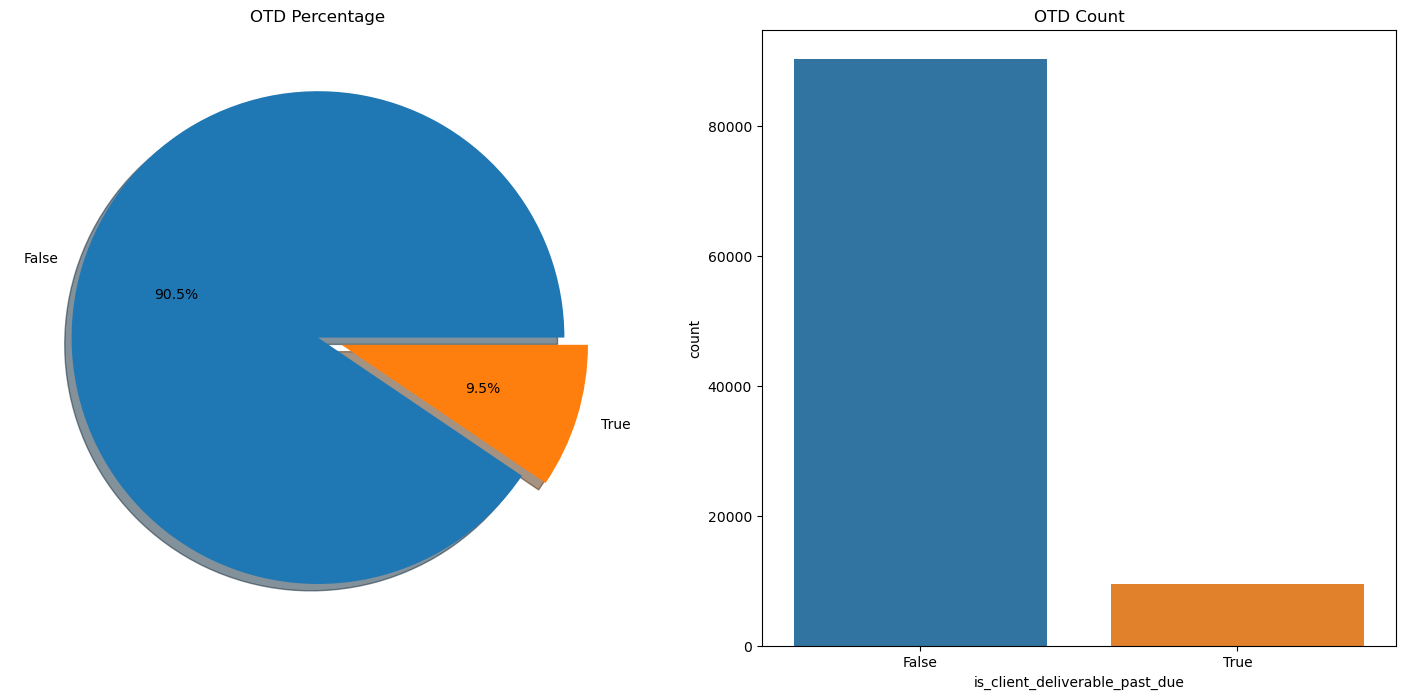

In [13]:
# How Many Delivered On Time?

f,ax=plt.subplots(1,2,figsize=(18,8))
deliverables['is_client_deliverable_past_due'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('OTD Percentage')
ax[0].set_ylabel('')
sns.countplot(x = 'is_client_deliverable_past_due',data=deliverables,ax=ax[1]) 
ax[1].set_title('OTD Count')
plt.show()

### Observation:

Percentage of non-OTD is around 10%. And after some discussion with stakeholder, customer expects 90-95% deliverables to be on time even though Welocalize aims for 100%. So year 2022 OTD metric was within range, but there is still room for improvement. 

# Analyzing Columns That Could Contribute to On Time Delivery (OTD)

In [14]:
# Dataset Timeframe
deliverables.date_client_deliverable_delivered.min(), deliverables.date_client_deliverable_delivered.max()

('2022-01-01', '2022-12-30')

Total timeframe of data is 364 days from year: 2022.

In [15]:
# Let's get different trends of OTD and non-OTD broken down by month and week.
monthly = pd.read_csv('/kaggle/input/welocalize/month_freqs.csv')
weekly = pd.read_csv('/kaggle/input/welocalize/week_freqs.csv')
month_day = pd.read_csv('/kaggle/input/welocalize/day_freqs.csv')
dow = pd.read_csv('/kaggle/input/welocalize/dow_freqs.csv')

OTD percent is total # of on time deliverables over total deliverables and for non-OTD vice versa.

### Monthly:

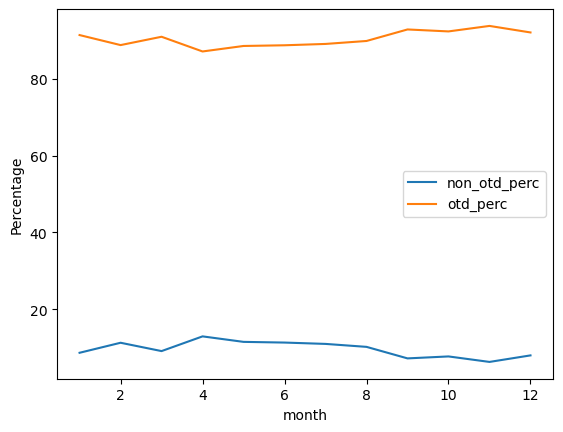

In [16]:
monthly.plot(x="month", y=["non_otd_perc", "otd_perc"])
plt.ylabel('Percentage')
plt.show()

This just shows us how big of a difference there is between OTD's and non-OTD's. 

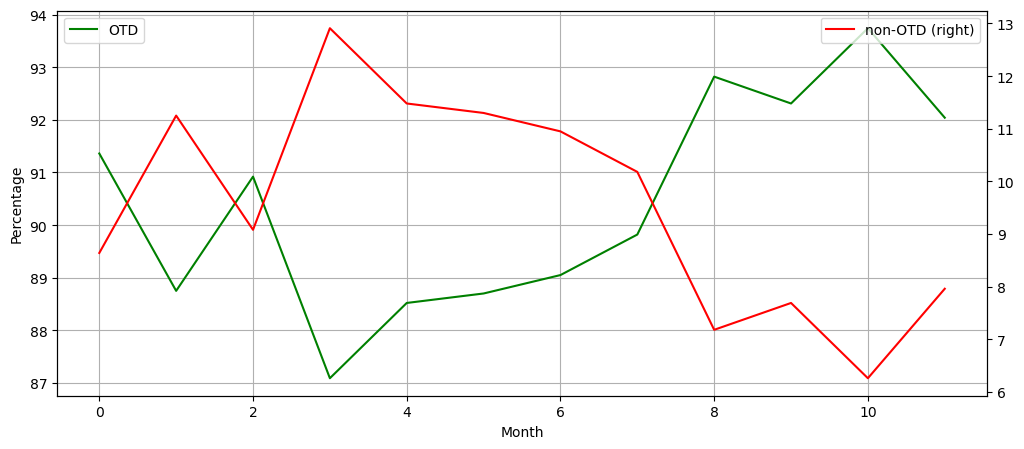

In [17]:
plt.figure(figsize=(12,5))
plt.xlabel('Month')
plt.ylabel('Percentage')

ax1 = monthly.otd_perc.plot(color='green', grid=True, label='OTD')
ax2 = monthly.non_otd_perc.plot(color='red', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

This graph is more illuminating because it let's us see better inflections within each percentage and between OTD's and non-OTD's, when trend is down, what is the relationship with the other graph. 

### Observation:
As we can see here is that OTD's hit a low in March and have peaked after that with a slight dip at end of the year. Would be interesting to see what contributed to non-OTD's in March and peak of OTD's in October.

### Weekly:

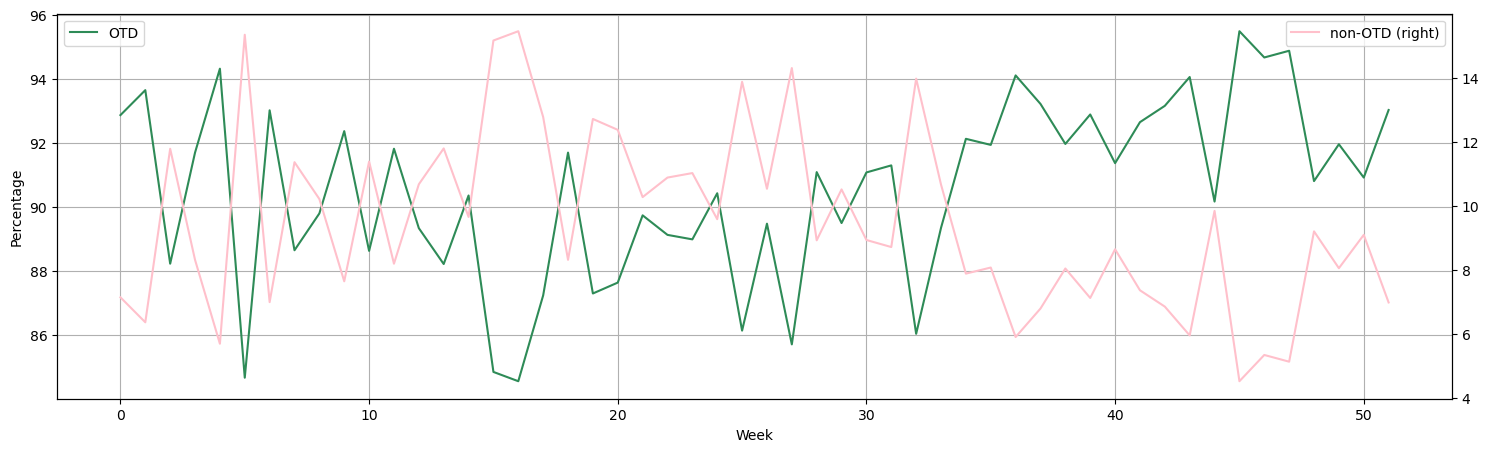

In [18]:
plt.figure(figsize=(18,5))
plt.xlabel('Week')
plt.ylabel('Percentage')

ax1 = weekly.otd_perc.plot(color='seagreen', grid=True, label='OTD')
ax2 = weekly.non_otd_perc.plot(color='pink', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

### Observation:

It gets more interesting at the weekly level. At this level of granularity, we see OTD's drop significantly every 10 weeks until appoximately 32nd week of 2022/August.

### Day of Month:

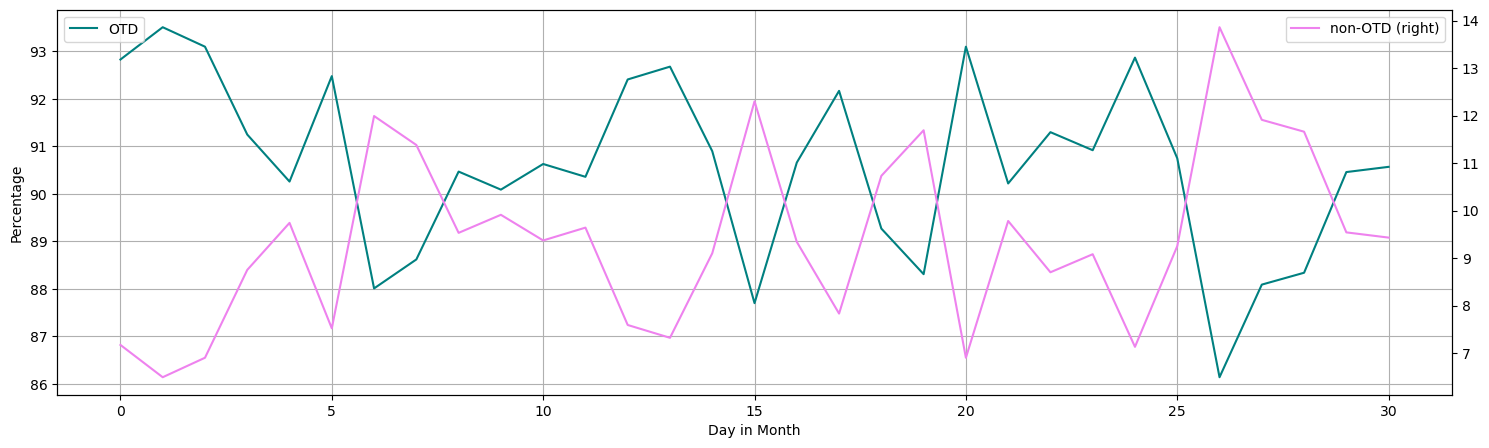

In [19]:
plt.figure(figsize=(18,5))
plt.xlabel('Day in Month')
plt.ylabel('Percentage')

ax1 = month_day.otd_perc.plot(color='teal', grid=True, label='OTD')
ax2 = month_day.non_otd_perc.plot(color='violet', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

### Day of Week:

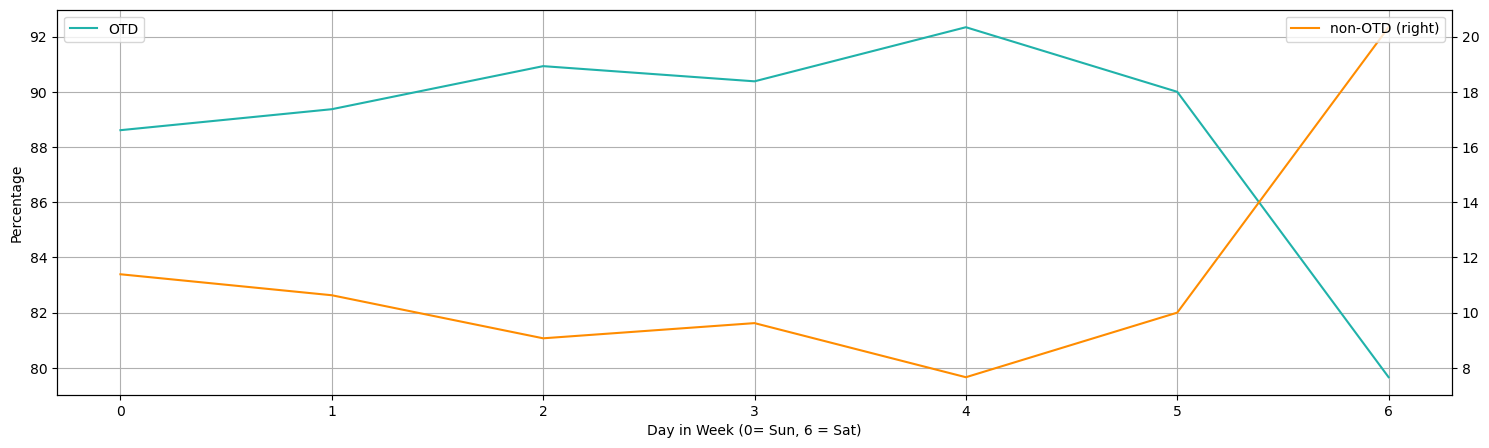

In [20]:
plt.figure(figsize=(18,5))
plt.xlabel('Day in Week (0= Sun, 6 = Sat)')
plt.ylabel('Percentage')

ax1 = dow.otd_perc.plot(color='lightseagreen', grid=True, label='OTD')
ax2 = dow.non_otd_perc.plot(color='darkorange', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

### Observation: 
Does not look like there are any interesting patterns/insights at day of month/day in week level.

In [21]:
deliverables.head()

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,lateness_of_client_deliverable_seconds,lateness_of_client_deliverable_days,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,NaN,NaN,False
1,1658115,2022-02-01,8,1344,NaN,NaN,False
2,1658124,2022-02-01,12,20714,NaN,NaN,False
3,1658129,2022-02-01,7,1344,NaN,NaN,False
4,1658134,2022-02-01,10,20714,NaN,NaN,False


# Continous Data
### Total Tasks 

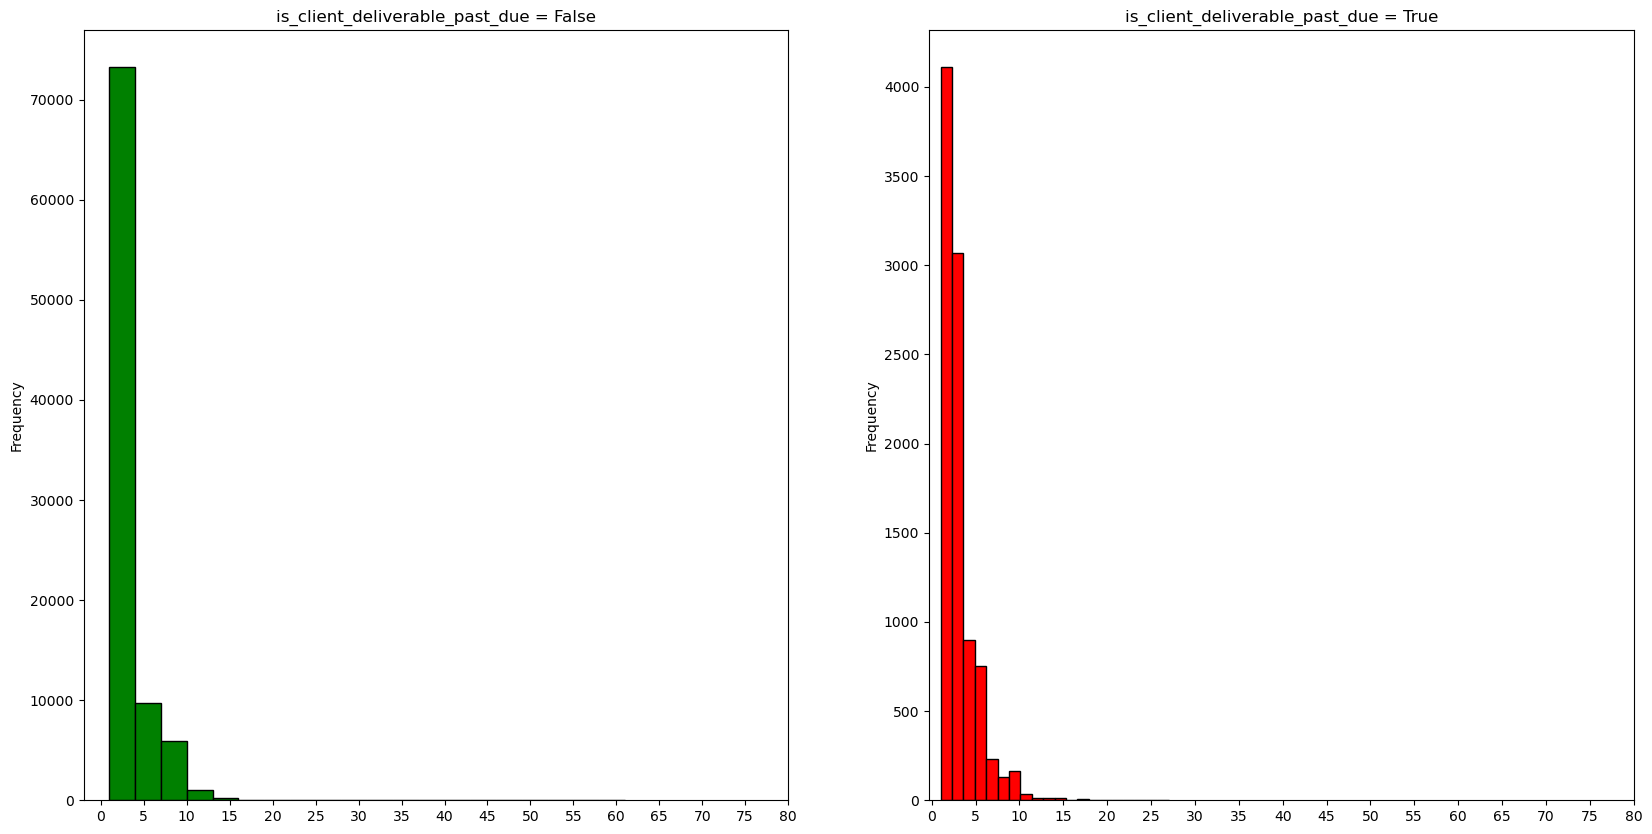

In [22]:
f,ax=plt.subplots(1,2,figsize=(20,10))
deliverables[deliverables['is_client_deliverable_past_due']==False].total_tasks.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='green')
ax[0].set_title('is_client_deliverable_past_due = False')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
deliverables[deliverables['is_client_deliverable_past_due']==True].total_tasks.plot.hist(ax=ax[1],bins=20,edgecolor='black',color='red')
ax[1].set_title('is_client_deliverable_past_due = True')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

### Observations:
1. For deliverables that were not delivered on time, more variety of total tasks per deliverable. 
2. Though both deliverables delivered on time and not on time are left skewed meaning most deliverables have low number of tasks. 
3. Most number of tasks for OTD was 15.
4. Most number of tasks for non-OTD was between 15 and 20. Looks like going beyond 15 did not help with OTD.

### Words, Lateness of client deliverable days

In [23]:
deliverables_otd = deliverables.loc[deliverables['is_client_deliverable_past_due'] == False]
deliverables_non_otd = deliverables.loc[deliverables['is_client_deliverable_past_due'] == True]
deliverables_otd2 = deliverables_otd[['words']]
deliverables_non_otd2 = deliverables_non_otd[['words', 'lateness_of_client_deliverable_days']]

<AxesSubplot:>

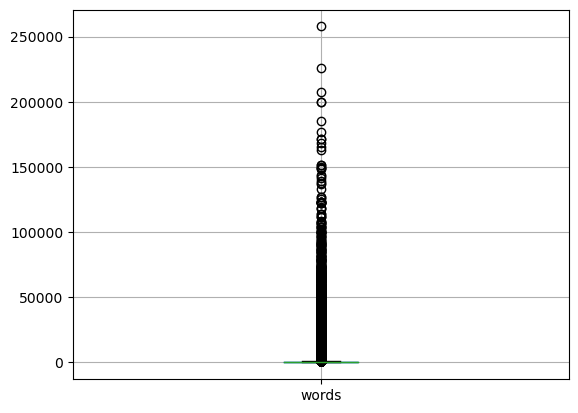

In [24]:
deliverables_otd2.boxplot()

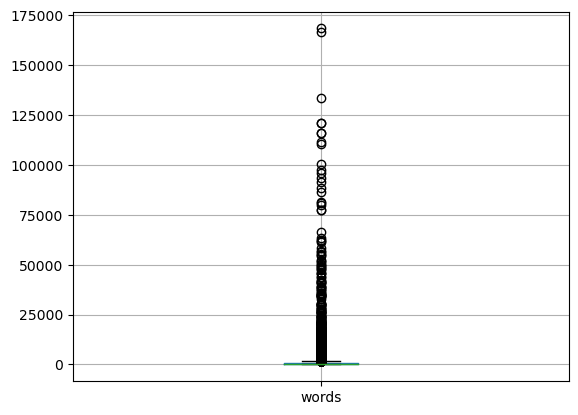

In [25]:
deliverables_non_otd2.boxplot(column=['words'], return_type='axes');

### Observations
1. Both distibutions have long upper whisker/outliers; lot of variance
2. Bulk of the outliers for total words in non-OTD is at lower total number of words (about half)
3. Max total words for OTD is approximately 75,000 more words

Text(0.5, 0, 'Lateness of Client Deliverable (Days)')

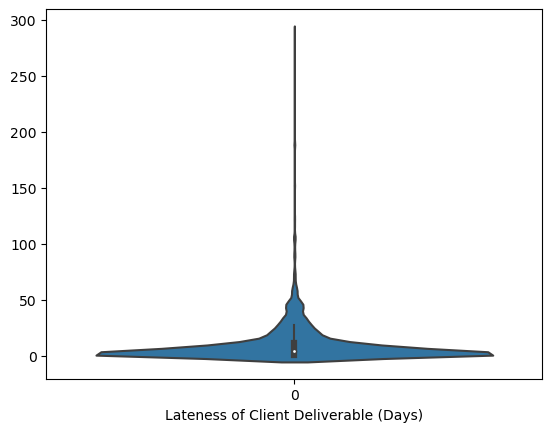

In [26]:
# lateness of delivery in days
sns.violinplot(deliverables.lateness_of_client_deliverable_days)
plt.xlabel("Lateness of Client Deliverable (Days)")

In [27]:
deliverables.lateness_of_client_deliverable_days.value_counts()

19.628054    24
11.629934    22
15.109029    21
25.396868    19
20.586388    16
             ..
4.403264      1
4.530662      1
5.317398      1
2.575194      1
0.001356      1
Name: lateness_of_client_deliverable_days, Length: 8720, dtype: int64

In [28]:
deliverables.lateness_of_client_deliverable_days.describe()

count    9437.000000
mean       10.326718
std        16.522251
min         0.000014
25%         1.110137
50%         4.815762
75%        11.629934
max       289.416480
Name: lateness_of_client_deliverable_days, dtype: float64

### Observation:
1. Most of the time, late delivery times were 10 days.
2. At the same time, there are some outliers that could be taken out such as maximum late time extending all the way out to about 10.5 months

### Correlations with OTD

# Strategy:

1. Determine if looking at correlation/association would make sense?
2. Determine types of variables and choose appropriate test for association from there
3. Get significance level and/or effect size for correlation/association
4. Interpret results (as x grows, so does y; as x decreases leads to OTD, as one is in a `particular category, more likely to be associated with OTD/non-OTD (need to break-down variable values to answer this)

### Before creating correlation matrix, need to create new columns:
* from delivery date: monthly, weekly columns
* change is_client_deliverable_past_due (True/False) to OTD (0/1) - (True late means 0 for OTD column)
* take out primary key
* only include time aggregaton at highest level of granularity

In [29]:
deliverables2 = deliverables.copy()

deliverables2['date_client_deliverable_delivered'] = pd.to_datetime(deliverables2['date_client_deliverable_delivered'])
deliverables2['date_client_deliverable_delivered_month'] = deliverables2['date_client_deliverable_delivered'].dt.month
deliverables2['date_client_deliverable_delivered_week'] = deliverables2['date_client_deliverable_delivered'].dt.isocalendar().week

deliverables2['is_client_deliverable_past_due'] = deliverables2['is_client_deliverable_past_due'].astype(int)
deliverables2['OTD'] = deliverables2['is_client_deliverable_past_due'].replace({0:1, 1:0})

deliverables3 = deliverables2[['date_client_deliverable_delivered_month', 'date_client_deliverable_delivered_week', 'total_tasks', 'words', 'lateness_of_client_deliverable_days', 'OTD']]

In [30]:
categorical_features=identify_nominal_columns(deliverables3)
categorical_features

[]

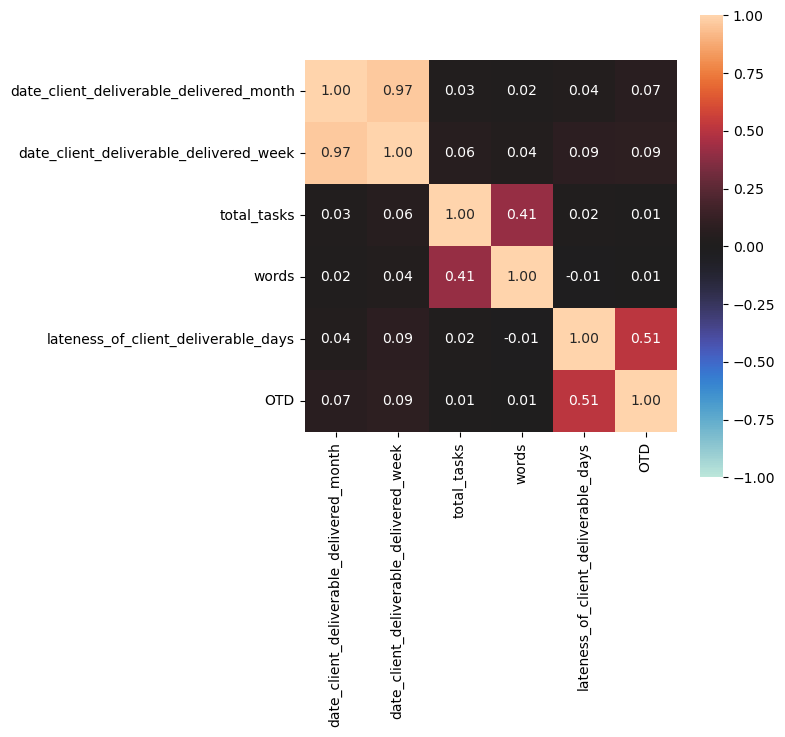

{'corr':                                          date_client_deliverable_delivered_month  \
 date_client_deliverable_delivered_month                                 1.000000   
 date_client_deliverable_delivered_week                                  0.967640   
 total_tasks                                                             0.025328   
 words                                                                   0.018589   
 lateness_of_client_deliverable_days                                     0.036006   
 OTD                                                                     0.066620   
 
                                          date_client_deliverable_delivered_week  \
 date_client_deliverable_delivered_month                                0.967640   
 date_client_deliverable_delivered_week                                 1.000000   
 total_tasks                                                            0.058195   
 words                                                     

In [31]:
complete_correlation= associations(deliverables3, nominal_columns = [
 'date_client_deliverable_delivered_month',
 'date_client_deliverable_delivered_week', 'OTD'], numerical_columns = [ 'total_tasks',
 'words', 'lateness_of_client_deliverable_days']#,cramers_v_bias_correction=False
                                   , figsize=(6,6))
complete_correlation

# Checking all observatons from EDA with Correlation/Association Heatmap

Dython package helped:

Calculate the correlation/strength-of-association of features in dataset with both categorical and continuous features using: * Pearson's R for continuous-continuous cases * Correlation Ratio for categorical-continuous cases * Cramer's V or Theil's U for categorical-categorical cases.

Interpreting Correlation:
    
POSITIVE CORRELATION: If an increase in column A leads to increase in column B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in column A leads to decrease in column B, then they are negatively correlated. A value -1 means perfect negative correlation.

At the same time, two columns can have highly/perfect correlation meaning no variation in information. This is known as **MultiColinearity** as both columns contain the same information. (e.g. lateness_of_client_deliverable_days and OTD)

Interpreting Correlation more closely and Association is Based on Cramer's V's Effect Sizes (explained more below).

Take-away's from deliverables' specific columns:
* What we observe is that there is not much correlation with OTD with these deliverable columns.
* Highest correlation is from a column that describes OTD in time. So 0.51 value is just Multi-Colinearity between lateness_of_client_deliverable_days and OTD. 
* Other relaively high correlation is the relationship that bigger tasks, have more words translated at 0.41, but this is multicollinearity as well.
* Therefore, not much to take away from here. There may be more to capture with numerical to binary associations we will inspect next.

In [32]:
# Checking correlations/associations
# Pearson's R: month/week x total tasks, month/week x words, month/week, late time, total tasks x words, total tasks x late time, words x late time
# Point Biserial Correlation: month/week to OTD, total tasks x OTD, words x OTD, late time x OTD
# Cramer's V: none

### Numerical - Numerical Correlations

Correlation Metric - Pearson's R Interpretation:

* Small: 0.1 - 0.3 /  -0.1 to -0.3
* Medium: 0.3 - 0.5 /  -0.3 to -0.5
* Large: >= 0.5 / <= -0.5

Significant correlations:
* Lateness of client deliverable days has large correlation, but is classified as multicollinearity as it is describing OTD. 
* total tasks and words (0.41) - medium effect, have multicollinearity as well because as total tasks increase so will number of words


### Numerical - Nominal Associations

The point-biserial correlation coefficient is a measure of the strength and direction of the relationship between a continuous variable (such as test scores) and a dichotomous variable (such as gender). It ranges from -1 to 1, where a value of 0 indicates no relationship, a value of -1 indicates a perfect negative relationship, and a value of 1 indicates a perfect positive relationship.

The interpretation of what is considered a "good" point-biserial correlation coefficient number depends on the specific context of the study and the research question. In general, a correlation coefficient of 0.1 to 0.3 may be considered a small effect size, 0.3 to 0.5 may be considered a medium effect size, and above 0.5 may be considered a large effect size.

However, it's important to note that the significance and interpretation of a correlation coefficient depend on factors such as sample size, measurement reliability, and the specific variables being studied. Therefore, it's important to interpret the point-biserial correlation coefficient in the context of the specific research question and study design.

In [33]:
deliverables3 = deliverables3.fillna(0)

In [34]:
deliverables_columns = ['date_client_deliverable_delivered_month',
 'date_client_deliverable_delivered_week',
 'total_tasks',
 'words',
 'lateness_of_client_deliverable_days']

In [35]:
def point_bi(column): 
    df = pd.DataFrame({'continuous_column': deliverables3[column],
                   'binary_column': deliverables3['OTD']})

    # split the continuous column by the binary column
    group1 = df.loc[df['binary_column'] == 0, 'continuous_column']
    group2 = df.loc[df['binary_column'] == 1, 'continuous_column']

    # calculate the point-biserial correlation coefficient and p-value
    corr, p = pointbiserialr(df['binary_column'], df['continuous_column'])

    # print the result
    print(column, 'x OTD Point-biserial correlation coefficient:', corr)

for c in deliverables_columns:
    point_bi(c)

date_client_deliverable_delivered_month x OTD Point-biserial correlation coefficient: 0.04101579766978592
date_client_deliverable_delivered_week x OTD Point-biserial correlation coefficient: 0.0389417800223968
total_tasks x OTD Point-biserial correlation coefficient: -0.010893641054206746
words x OTD Point-biserial correlation coefficient: -0.005455105986115237
lateness_of_client_deliverable_days x OTD Point-biserial correlation coefficient: -0.5107156654307742


Point-Biserial Correlation Coefficient Effect Size:

* Small: 0.1 - 0.3 / -0.1 to -0.3
* Medium: 0.3 - 0.5 / -0.3 to -0.5
* Large: >= 0.5 / <= -0.5

This is definitely a lot more telling and accurate metric. Though there is similarity where multicollinear columns such as month/week, total tasks/words have similar numbers. They still have very low association with OTD. 

At least with total tasks and words we see that the lower the number, the higher the association with OTD, but this association is below small effect size.
Lastly, lateness of deliverable day shows correct direction as with lower the number of late days as we go from non-OTD to OTD. This is a multicollinear column to OTD so not too much new information.

# Other Insights
## Requests

* Project manager can have multiple deliverables. 
* And these can be delivered on time or not.
* So focus is on requests, but data is fanned out since working at deliverables level that are under requests (expect duplicate project manager id's)

In [36]:
requests2 = requests[['average_duration_request_received_to_quoted_business_days', 'project_manager_id','requests_managed_simultaneously_by_project_manager','service_line','is_client_deliverable_past_due']]
requests2.head()

,average_duration_request_received_to_quoted_business_days,project_manager_id,requests_managed_simultaneously_by_project_manager,service_line,is_client_deliverable_past_due
0,0.064494,3424244246268217782,816,Legal & Financial Services,False
1,0.066802,3908128739217598266,324,Legal & Financial Services,False
2,0.066802,3908128739217598266,324,Legal & Financial Services,False
3,0.066802,3908128739217598266,324,Legal & Financial Services,False
4,0.066802,3908128739217598266,324,Legal & Financial Services,False


In [37]:
requests2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99697 entries, 0 to 99696
Data columns (total 5 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   average_duration_request_received_to_quoted_business_days  1579 non-null   float64
 1   project_manager_id                                         99697 non-null  int64  
 2   requests_managed_simultaneously_by_project_manager         99697 non-null  int64  
 3   service_line                                               99697 non-null  object 
 4   is_client_deliverable_past_due                             99697 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 3.1+ MB


In [38]:
requests2[['average_duration_request_received_to_quoted_business_days','requests_managed_simultaneously_by_project_manager','is_client_deliverable_past_due']].describe()

,average_duration_request_received_to_quoted_business_days,requests_managed_simultaneously_by_project_manager
count,1579.000000,99697.000000
mean,2.295781,221.800907
std,13.384030,771.741312
min,0.000000,1.000000
25%,0.053655,28.000000
50%,0.140162,55.000000
75%,0.369256,103.000000
max,166.223669,5759.000000


In [39]:
requests2.isnull().sum()

average_duration_request_received_to_quoted_business_days    98118
project_manager_id                                               0
requests_managed_simultaneously_by_project_manager               0
service_line                                                     0
is_client_deliverable_past_due                                   0
dtype: int64

### Observations:
* Remember, average_duration_request_received_to_quoted_business_days is heavily sparse because not a strict requirement for tasks to get started if client has been one for a while.
* With sparse data in that column, usually takes 2 days to get quote for client.
* Average number of requests managed by one project manager is huge: 222 with the max close to 6000. 

### Types of Columns:

** Qualitative:
* Categorical: service_line, project_manager_id
* Binary: is_client_deliverable_past_due

** Quantitative:
* Continuous: average_duration_request_received_to_quoted_business_days,
* Discrete: requests_managed_simultaneously_by_project_manager 

### Service Line 

In [40]:
requests2.groupby(['service_line','is_client_deliverable_past_due'])['is_client_deliverable_past_due'].count()

service_line                is_client_deliverable_past_due
Legal & Financial Services  False                              5635
                            True                                310
Life Sciences               False                              8675
                            True                                429
Localization                False                             75935
                            True                               8713
Name: is_client_deliverable_past_due, dtype: int64

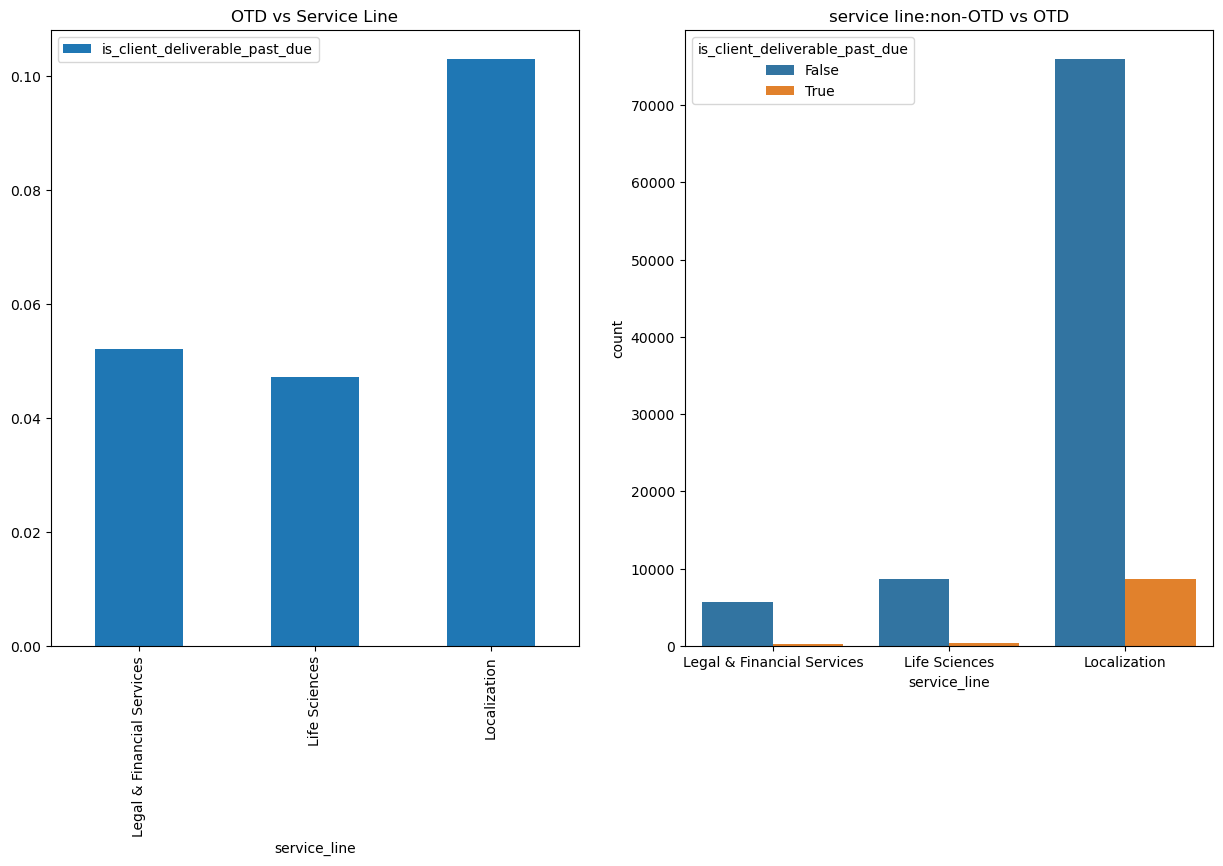

In [41]:
f,ax=plt.subplots(1,2,figsize=(15,8))
requests2[['service_line','is_client_deliverable_past_due']].groupby(['service_line']).mean().plot.bar(ax=ax[0])
ax[0].set_title('OTD vs Service Line')
sns.countplot(x='service_line',hue='is_client_deliverable_past_due',data=requests2,ax=ax[1])
ax[1].set_title('service line:non-OTD vs OTD')
plt.show()

* Localization deliverables are highest in number.
* Localization has the highest number of non-OTD's as well as the highest difference between OTD and non-OTD deliverables.

### Project Manager ID

In [42]:
requests2_otd = requests2.loc[requests2['is_client_deliverable_past_due'] == False]
requests2_non_otd = requests2.loc[requests2['is_client_deliverable_past_due'] == True]

<AxesSubplot:>

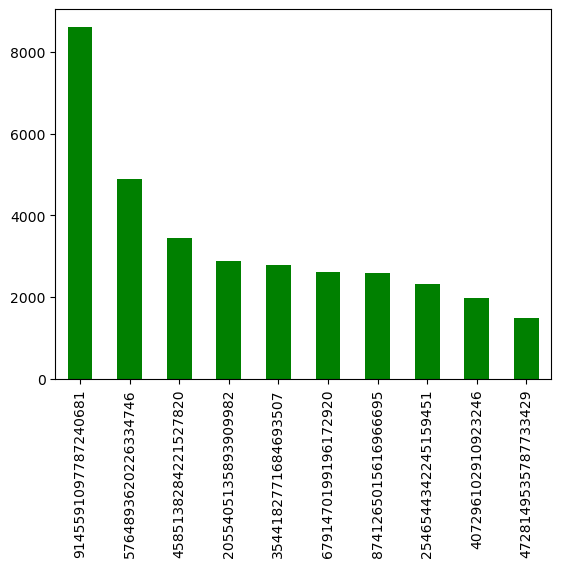

In [43]:
requests2_otd.project_manager_id.value_counts()[:10].plot(kind='bar', color='green')

<AxesSubplot:>

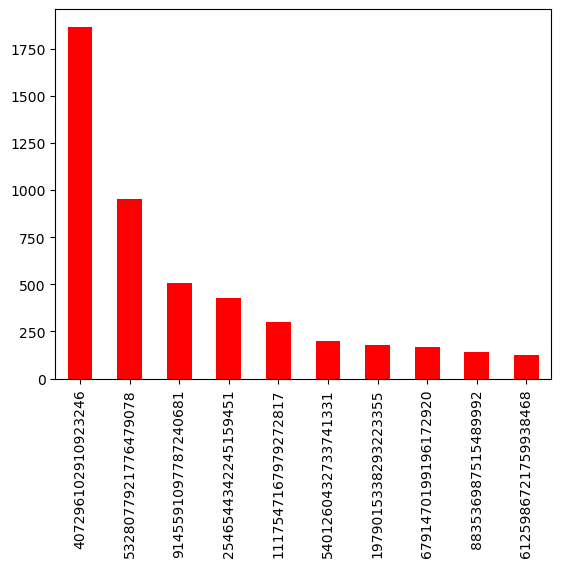

In [44]:
requests2_non_otd.project_manager_id.value_counts()[:10].plot(kind='bar', color = 'red')

Let's see how many projects these project managers have on their plate?

In [45]:
bad_pm = requests2_non_otd.project_manager_id.value_counts()[:10].index
bad_pm_deliverables = requests2[requests2['project_manager_id'].isin(bad_pm)]
bad_pm_deliverables.groupby('project_manager_id')['requests_managed_simultaneously_by_project_manager'].max().reset_index().sort_values(by='requests_managed_simultaneously_by_project_manager',ascending=False)

,project_manager_id,requests_managed_simultaneously_by_project_manager
0,407296102910923246,5759
5,5328077921776479078,780
9,9145591097787240681,600
6,5401260432733741331,383
1,883536987515489992,245
2,1117547167979272817,184
3,1979015338293223355,143
4,2546544342245159451,141
7,6125986721759938468,75
8,6791470199196172920,65


Comparing this to those who have delivered their deliverables on time:

In [46]:
good_pm = requests2_otd.project_manager_id.value_counts()[:10].index
good_pm_deliverables = requests2[requests2['project_manager_id'].isin(good_pm)]
good_pm_deliverables.groupby('project_manager_id')['requests_managed_simultaneously_by_project_manager'].max().reset_index().sort_values(by='requests_managed_simultaneously_by_project_manager',ascending=False)

,project_manager_id,requests_managed_simultaneously_by_project_manager
0,407296102910923246,5759
3,3544182771684693507,1535
9,9145591097787240681,600
6,5764893620226334746,256
5,4728149535787733429,229
2,2546544342245159451,141
8,8741265015616966695,122
4,4585138284221527820,84
1,2055405135893909982,76
7,6791470199196172920,65


In [47]:
requests2_otd.project_manager_id.value_counts()[:10].index

Int64Index([9145591097787240681, 5764893620226334746, 4585138284221527820,
            2055405135893909982, 3544182771684693507, 6791470199196172920,
            8741265015616966695, 2546544342245159451,  407296102910923246,
            4728149535787733429],
           dtype='int64')

In [48]:
requests2_otd.project_manager_id.value_counts()[:10].index.isin(bad_pm)

array([ True, False, False, False, False,  True, False,  True,  True,
       False])

* Looks like there are project managers who are delivering on time and not on time. 
* We also see that workload difference is not a big indicator of whether or not a project manager will have otd/non-otd.

Would be good to see correlation matrix to see what sort of request attribute contributes most to otd/non-otd.

### Average duration request received to quoted business days

In [49]:
#Let's remind ourselves of the distribution
requests2.average_duration_request_received_to_quoted_business_days.describe()

count    1579.000000
mean        2.295781
std        13.384030
min         0.000000
25%         0.053655
50%         0.140162
75%         0.369256
max       166.223669
Name: average_duration_request_received_to_quoted_business_days, dtype: float64

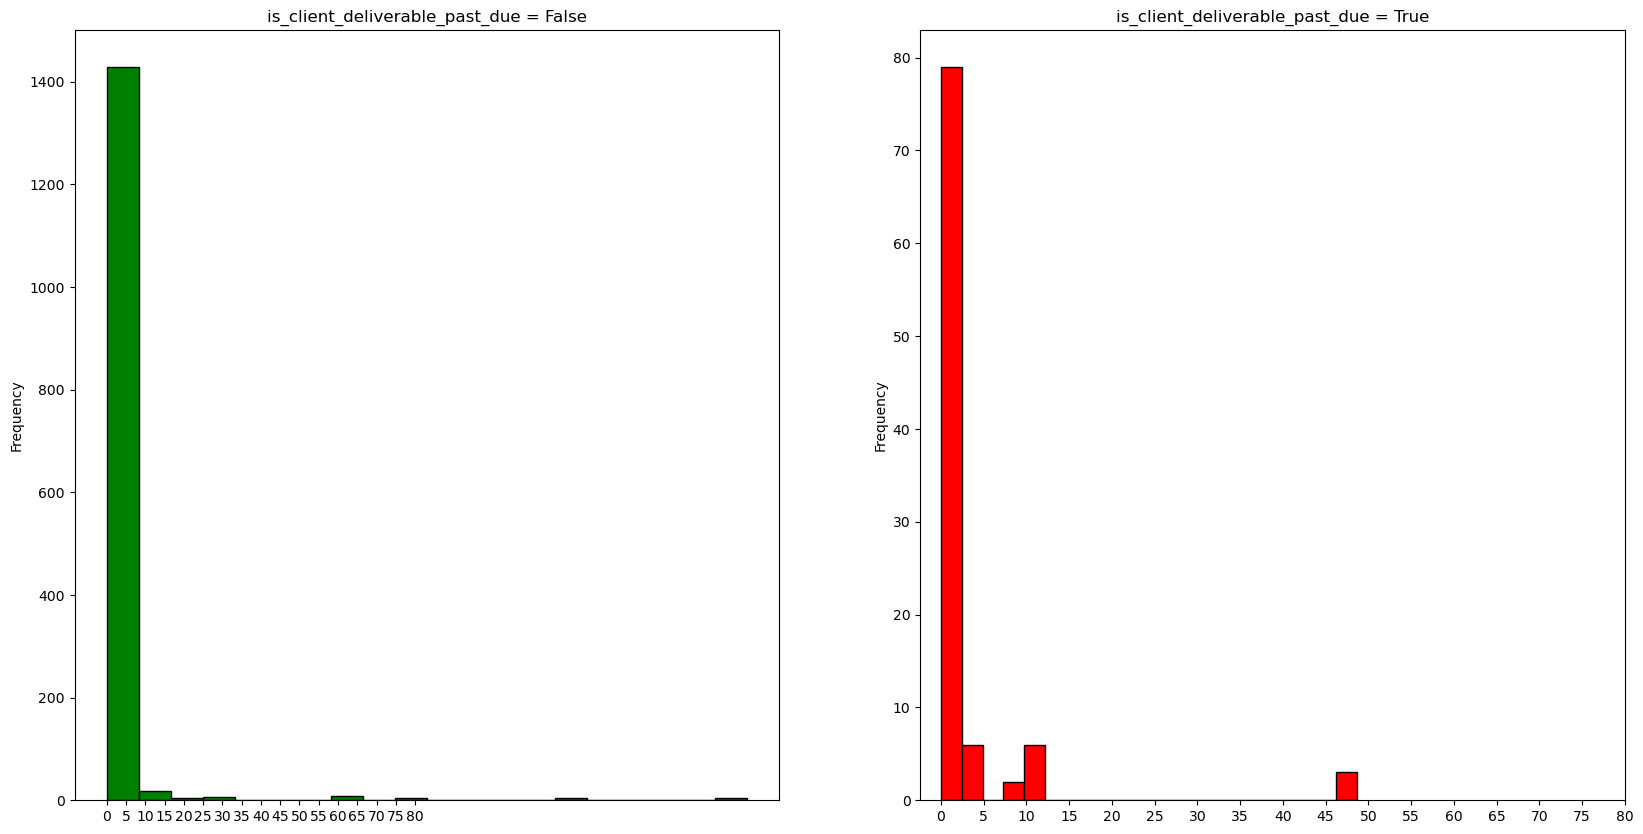

In [50]:
f,ax=plt.subplots(1,2,figsize=(20,10))
requests2[requests2['is_client_deliverable_past_due']==False].average_duration_request_received_to_quoted_business_days.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='green')
ax[0].set_title('is_client_deliverable_past_due = False')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
requests2[requests2['is_client_deliverable_past_due']==True].average_duration_request_received_to_quoted_business_days.plot.hist(ax=ax[1],bins=20,edgecolor='black',color='red')
ax[1].set_title('is_client_deliverable_past_due = True')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

This has very sparse data. So it would be difficult to make a connection between time takes for quote to be given and OTD success. However, with the given data looks like quotes were usually given quickly, but seems to not be significant for there to be deliverable to be made on time. There is a lot of variance in quotes even though deliverable was completed on time.

### requests managed simulataneously by manager

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


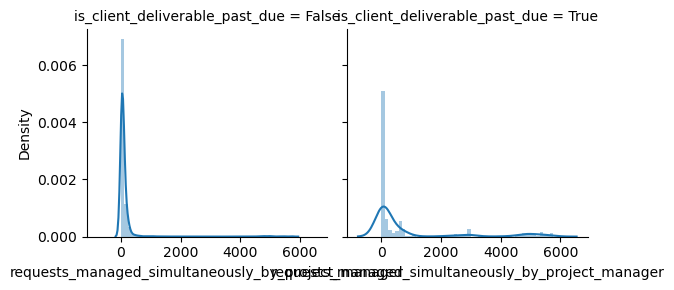

In [51]:
g = sns.FacetGrid(requests2, col='is_client_deliverable_past_due')
g = g.map(sns.distplot, "requests_managed_simultaneously_by_project_manager")

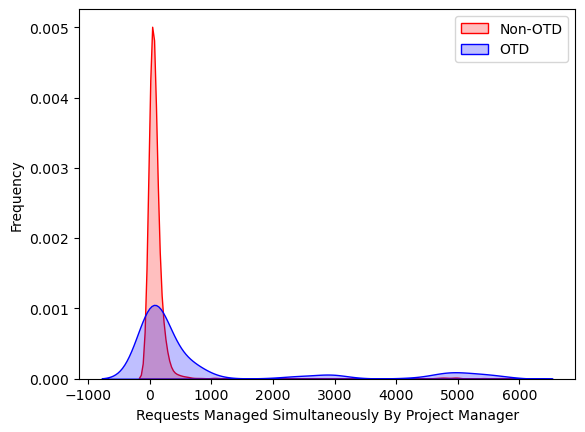

In [52]:
# Explore requests_managed_simultaneously_by_project_manager distibution 
g = sns.kdeplot(requests2["requests_managed_simultaneously_by_project_manager"][(requests2["is_client_deliverable_past_due"] == 0) & (requests2["requests_managed_simultaneously_by_project_manager"].notnull())], color="Red", fill = True)
g = sns.kdeplot(requests2["requests_managed_simultaneously_by_project_manager"][(requests2["is_client_deliverable_past_due"] == 1) & (requests2["requests_managed_simultaneously_by_project_manager"].notnull())], ax =g, color="Blue", fill = True)
g.set_xlabel("Requests Managed Simultaneously By Project Manager")
g.set_ylabel("Frequency")
g = g.legend(["Non-OTD","OTD"])

Last, but not least, let's see if any request level columns correlate with OTD. With what we have seen so far, the assumption is not much except for service line.
* change is_client_deliverable_past_due to OTD (swap True -> 0)

In [53]:
requests2['is_client_deliverable_past_due'] = requests2['is_client_deliverable_past_due'].astype(int)
requests2['OTD'] = requests2['is_client_deliverable_past_due'].replace({0:1, 1:0})

requests2.drop(columns=['is_client_deliverable_past_due'], inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Using Pivot tables

In [54]:
pm_pivot = requests2[['project_manager_id', 'OTD']].groupby(['project_manager_id'], as_index=False).mean().sort_values(by='OTD', ascending=False)
pm_pivot

,project_manager_id,OTD
171,5427501383688990206,1.0
272,8208718030811333744,1.0
75,2470938891198065101,1.0
232,6882671242172894545,1.0
172,5461718139137806682,1.0
...,...,...
265,8030639247759478480,0.0
166,5297194836308943147,0.0
51,1449167541760323185,0.0
58,1718651078195006355,0.0


In [55]:
#significant correlation > 0.5
pm_sig = pm_pivot.loc[pm_pivot['OTD'] > 0.5]
pm_sig

,project_manager_id,OTD
171,5427501383688990206,1.000000
272,8208718030811333744,1.000000
75,2470938891198065101,1.000000
232,6882671242172894545,1.000000
172,5461718139137806682,1.000000
...,...,...
143,4652018709060727540,0.653846
296,8862036133218345776,0.648485
247,7498432840951024382,0.631579
187,5793494300243271385,0.527778


* Observations: 291 project managers have significant correlation

In [56]:
# Percent of significant project managers out of all project managers
len(pm_sig)/requests2.project_manager_id.nunique()

0.9326923076923077

In [57]:
#how many of the original dataset has pm's that showed significant correlation out of all deliverables?
len(requests2.loc[requests2['project_manager_id'].isin(pm_sig.project_manager_id)])/len(requests2)

0.9775720432911722

In [58]:
requests2[['service_line', 'OTD']].groupby(['service_line'], as_index=False).mean().sort_values(by='OTD', ascending=False)

,service_line,OTD
1,Life Sciences,0.952878
0,Legal & Financial Services,0.947855
2,Localization,0.897068


Observation: Service Line consistently has strong correlation with OTD.

In [59]:
categorical_features=identify_nominal_columns(requests2)
categorical_features

['service_line']

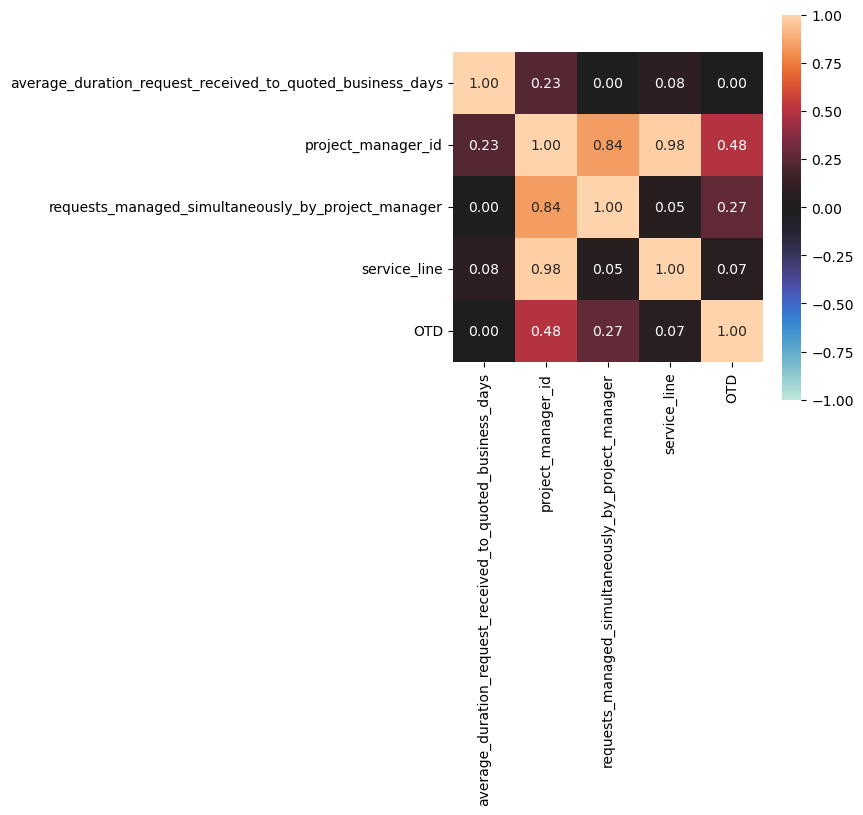

{'corr':                                                     average_duration_request_received_to_quoted_business_days  \
 average_duration_request_received_to_quoted_bus...                                           1.000000           
 project_manager_id                                                                           0.232023           
 requests_managed_simultaneously_by_project_manager                                           0.000164           
 service_line                                                                                 0.083999           
 OTD                                                                                          0.001574           
 
                                                     project_manager_id  \
 average_duration_request_received_to_quoted_bus...            0.232023   
 project_manager_id                                            1.000000   
 requests_managed_simultaneously_by_project_manager            0.840749   
 servi

In [60]:
# Will need to explicitly declare nominal/categorical and numerical columns since function above did not output right ones most likely due to data type
complete_correlation= associations(requests2
                                   , nominal_columns = ['project_manager_id', 'service_line', 'OTD'], numerical_columns = ['average_duration_request_received_to_quoted_business_days', 'requests_managed_simultaneously_by_project_manager'], figsize=(5,5))
complete_correlation

### Observations (numerical - numerical and nominal - nominal only):

* Highest correlation to OTD is project manager ID.
* project manager and service line 

## Correlation (Numerical-Numerical)
* Between time to get request and number of requests completed by PM have non-sensible relationship because there is not enough data for request time even though request time may have an influence on how many requests a PM has, but we already know this is not the case

## Association (Numerical - Binary)
### point-biserial correlation coefficient

In [61]:
requests2 = requests2.fillna(0)

In [62]:
requests_num_cols = requests2[['average_duration_request_received_to_quoted_business_days', 'requests_managed_simultaneously_by_project_manager']]

In [63]:
def req_cramersv(column):

    df = pd.DataFrame({'continuous_column': requests2[column].fillna(0),
                   'binary_column': requests2['OTD']})

    # split the continuous column by the binary column
    group1 = df.loc[df['binary_column'] == 0, 'continuous_column']
    group2 = df.loc[df['binary_column'] == 1, 'continuous_column']

    # calculate the point-biserial correlation coefficient and p-value
    corr, p = pointbiserialr(df['binary_column'], df['continuous_column'])

    # print the result
    print(column, " x OTD Point-biserial correlation coefficient:", corr)

for c in requests_num_cols:
    req_cramersv(c)

average_duration_request_received_to_quoted_business_days  x OTD Point-biserial correlation coefficient: 0.001573562696996155
requests_managed_simultaneously_by_project_manager  x OTD Point-biserial correlation coefficient: -0.2725832814770777


## Interpretation: 

Point-Biserial Correlation Coefficient Effect Size:

* Small: 0.1 - 0.3 / -0.1 to -0.3
* Medium: 0.3 - 0.5 / -0.3 to -0.5
* Large: >= 0.5 / <= -0.5

1. As we go from non-OTD to OTD, there is a non-existent correlation in quote time because: 1. we know the business has clients who have been with them for a while and this means that a quote is not needed to start work. 2. data is extremely sparse
2. For requests managed by PM's, as we go from non-OTD to OTD, we see that the correlation is small and in the negative direction. This means that less requests there are the more OTD deliverables there are. 

## Cramer's V 
Caveat: Short-coming with Cramer's V is that assumes symmetry of relationship: x -> y = y <- x, but this is not the case with Thiel's U which tells us direction

### Interpretation of Cramer's V 
(these need to consider interpretation of measures of association is always relative to the discipline, the specific data, and the aims of the analyst): 

* 0 means no association and 1 is full association
* Small: 0.10 – < 0.30
* Medium: 0.30 – < 0.50
* Large: ≥ 0.50 

Conclusion: 
* There is a medium association between project manager assigned to deliverable and it being OTD. 
* There is very strong association between service line and project manager but this association is just telling you which service line has which project managers..

In [64]:
requests2.groupby('service_line')['project_manager_id'].nunique()

service_line
Legal & Financial Services     48
Life Sciences                  77
Localization                  226
Name: project_manager_id, dtype: int64

## Translation Task

*  Within each deliverable there are multiple tasks including translation tasks. 
*  Each translation task has its own linquist/translator. 
*  Because each row is unique according to client_deliverable_id, all connected tasks are one task to one deliverable

In [65]:
translation_task.head()

,translations_for_client_by_supplier_to_date,average_duration_offer_sent_to_task_claimed_seconds,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_seconds,average_duration_task_claimed_to_task_started_days,source_language_locale_code,target_language_locale_code,content_specialty,translation_supplier_id,is_client_deliverable_past_due
0,1,103048.0,28.624444,124904.0,1.445648,en-US,ja-JP,Chemistry,Pantheon_11922,False
1,33,157246.0,43.679444,188189.0,2.178113,en-US,sq-AL,Chemistry,Pantheon_5920,False
2,13,352535.0,97.926389,205806.0,2.382014,en-US,el-GR,Chemistry,Pantheon_5881,False
3,16,204319.0,56.755278,193394.0,2.238356,en-US,lt-LT,Chemistry,Pantheon_5922,False
4,8,354784.0,98.551111,339963.0,3.934757,en-US,pt-PT,Chemistry,Pantheon_6813,False


In [66]:
translation_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99697 entries, 0 to 99696
Data columns (total 10 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   translations_for_client_by_supplier_to_date            99697 non-null  int64  
 1   average_duration_offer_sent_to_task_claimed_seconds    92869 non-null  float64
 2   average_duration_offer_sent_to_task_claimed_hours      92869 non-null  float64
 3   average_duration_task_claimed_to_task_started_seconds  98390 non-null  float64
 4   average_duration_task_claimed_to_task_started_days     98390 non-null  float64
 5   source_language_locale_code                            99697 non-null  object 
 6   target_language_locale_code                            99697 non-null  object 
 7   content_specialty                                      99697 non-null  object 
 8   translation_supplier_id                       

In [67]:
translation_task.isnull().sum()

translations_for_client_by_supplier_to_date                 0
average_duration_offer_sent_to_task_claimed_seconds      6828
average_duration_offer_sent_to_task_claimed_hours        6828
average_duration_task_claimed_to_task_started_seconds    1307
average_duration_task_claimed_to_task_started_days       1307
source_language_locale_code                                 0
target_language_locale_code                                 0
content_specialty                                           0
translation_supplier_id                                     0
is_client_deliverable_past_due                              0
dtype: int64

In [68]:
translation_task.describe()

,translations_for_client_by_supplier_to_date,average_duration_offer_sent_to_task_claimed_seconds,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_seconds,average_duration_task_claimed_to_task_started_days
count,99697.000000,9.286900e+04,92869.000000,9.839000e+04,98390.000000
mean,2298.606307,5.458206e+04,15.161682,1.211722e+05,1.402456
std,2991.265194,1.303046e+05,36.195716,2.110186e+05,2.442345
min,1.000000,1.000000e+00,0.000278,0.000000e+00,0.000000
25%,237.000000,2.617000e+03,0.726944,1.006025e+04,0.116438
50%,1255.000000,1.445500e+04,4.015278,5.282900e+04,0.611447
75%,3069.000000,4.805500e+04,13.348611,1.452282e+05,1.680883
max,14089.000000,3.508645e+06,974.623611,6.558920e+06,75.913426


### Observations for numerical values: 
* a supplier can do on average 3000 translations in one year (8/day) with max: 14,000 (38/day)
* Average time it takes for Welocalize to accept task: 54582 seconds/15 hours with max time: 40 days
* Average time it takes for Welocalize to start accepted task: 1.4 days

## Data Types:
    
This set is predominantly categorical.

* Numeric: translations_for_client_by_supplier_to_date, average_duration_offer_sent_to_task_claimed_hours, average_duration_task_claimed_to_task_started_days
* Categorical: source_language_locale_code, target_language_locale_code, content_specialty, translation_supplier_id, is_client_deliverable_past_due

### 

### translations_for_client_by_supplier_to_date

In [69]:
translation_task.translations_for_client_by_supplier_to_date.describe()

count    99697.000000
mean      2298.606307
std       2991.265194
min          1.000000
25%        237.000000
50%       1255.000000
75%       3069.000000
max      14089.000000
Name: translations_for_client_by_supplier_to_date, dtype: float64

Huge amount of variance. See if there is a difference when data is split between those with OTD and non-OTD deliverables.

Let's split between OTD and non-OTD.

In [70]:
task_otd = translation_task.loc[translation_task['is_client_deliverable_past_due'] == False]
task_non_otd = translation_task.loc[translation_task['is_client_deliverable_past_due'] == True]

Text(0.5, 0, 'OTD - translations for client by supplier to date')

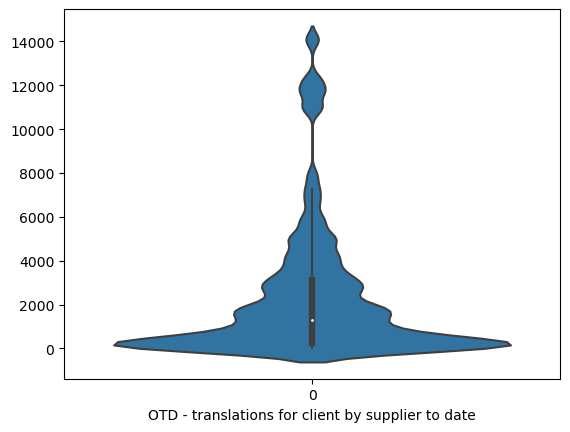

In [71]:
sns.violinplot(task_otd.translations_for_client_by_supplier_to_date)
plt.xlabel("OTD - translations for client by supplier to date")

<AxesSubplot:>

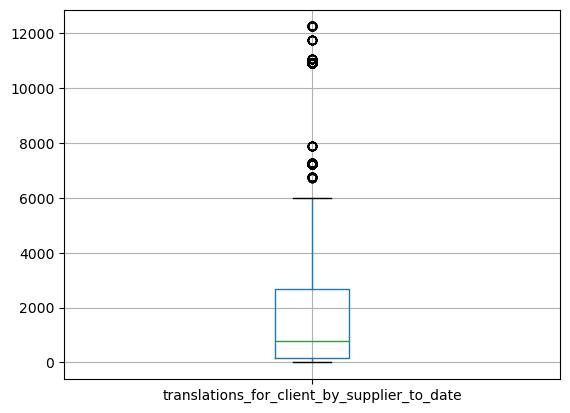

In [72]:
task_non_otd.boxplot(column='translations_for_client_by_supplier_to_date')

### average_duration_offer_sent_to_task_claimed_hours, average_duration_task_claimed_to_task_started_days

In [73]:
task_otd2 = task_otd[['average_duration_offer_sent_to_task_claimed_hours', 'average_duration_task_claimed_to_task_started_days']]
task_non_otd2 = task_non_otd[['average_duration_offer_sent_to_task_claimed_hours', 'average_duration_task_claimed_to_task_started_days']]

<AxesSubplot:>

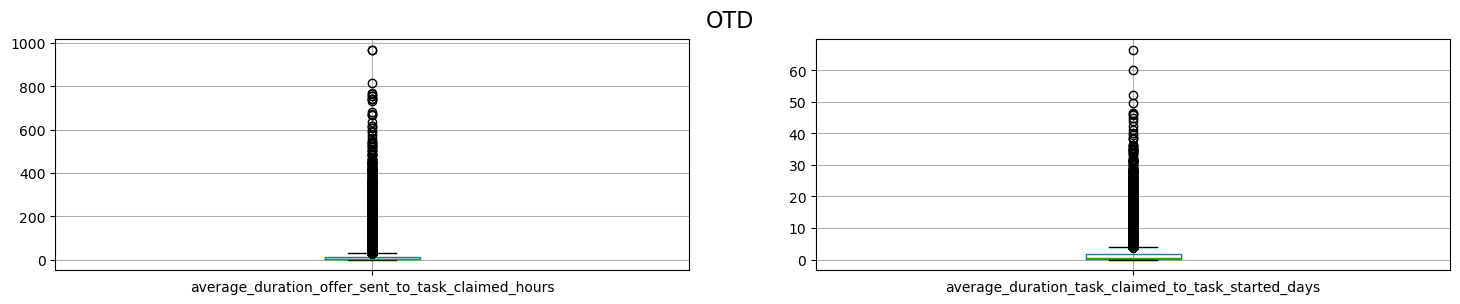

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(18, 3))
fig.suptitle('OTD', fontsize=16)
task_otd2.boxplot('average_duration_offer_sent_to_task_claimed_hours', ax=ax[0])
task_otd2.boxplot('average_duration_task_claimed_to_task_started_days', ax=ax[1])

<AxesSubplot:>

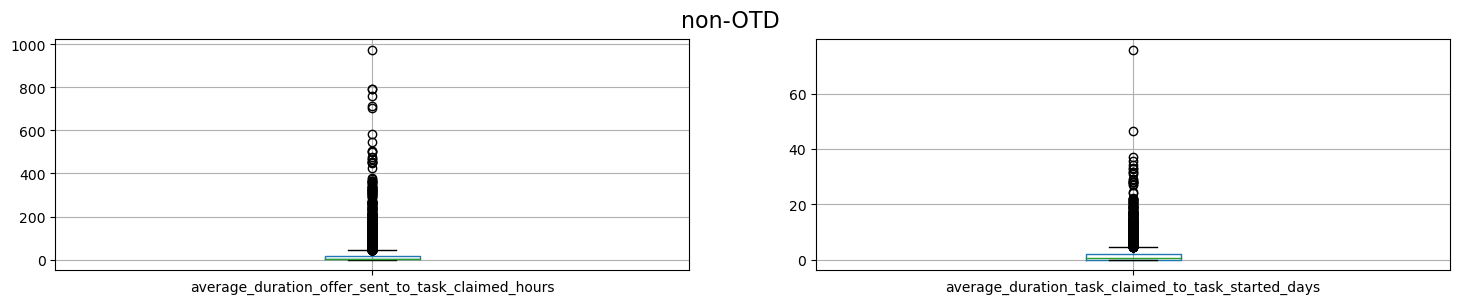

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(18, 3))
fig.suptitle('non-OTD', fontsize=16)
task_non_otd2.boxplot('average_duration_offer_sent_to_task_claimed_hours', ax=ax[0])
task_non_otd2.boxplot('average_duration_task_claimed_to_task_started_days', ax=ax[1])


### Observations:
1. Took worker longer to accept task for OTD's. (More vetted)
2. Took OTD tasks' longer to start with wider range of outliers within 40-day timespan (More deliberation)

### source_language_locale_code

<AxesSubplot:>

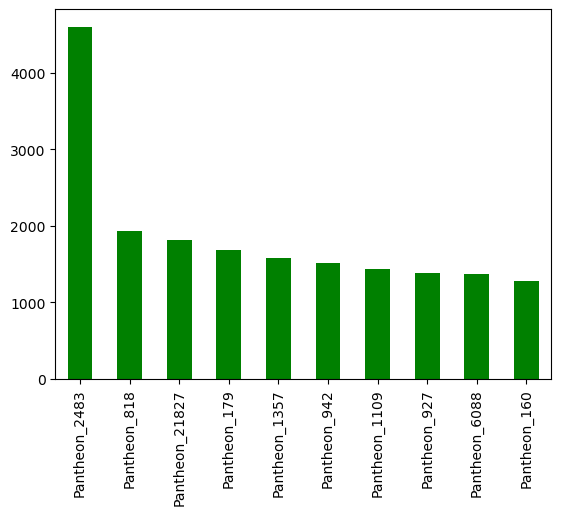

In [76]:
task_otd.translation_supplier_id.value_counts()[:10].plot(kind='bar', color = 'green')

<AxesSubplot:>

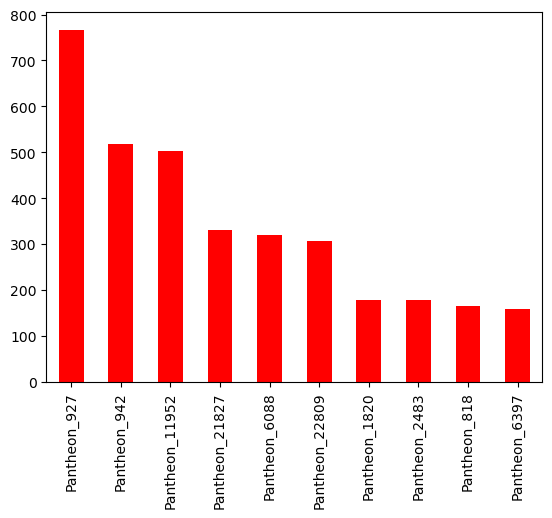

In [77]:
task_non_otd.translation_supplier_id.value_counts()[:10].plot(kind='bar', color = 'red')

In [78]:
good_translator = task_otd.translation_supplier_id.value_counts()[:10].index
good_translator_deliverables = translation_task[translation_task['translation_supplier_id'].isin(good_translator)]
good_tr_cnt = good_translator_deliverables.groupby('translation_supplier_id')['translations_for_client_by_supplier_to_date'].max().reset_index().sort_values(by='translations_for_client_by_supplier_to_date',ascending=False)
good_tr_cnt

,translation_supplier_id,translations_for_client_by_supplier_to_date
5,Pantheon_2483,14089
1,Pantheon_1357,11746
3,Pantheon_179,11724
9,Pantheon_942,10925
8,Pantheon_927,7238
7,Pantheon_818,6186
4,Pantheon_21827,5192
0,Pantheon_1109,5055
6,Pantheon_6088,3805
2,Pantheon_160,3101


In [79]:
good_tr_cnt.describe()

,translations_for_client_by_supplier_to_date
count,10.000000
mean,7906.100000
std,3879.739695
min,3101.000000
25%,5089.250000
50%,6712.000000
75%,11524.250000
max,14089.000000


<AxesSubplot:>

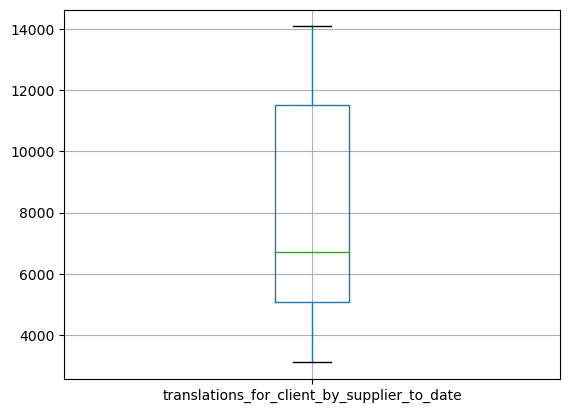

In [80]:
good_tr_cnt.boxplot()

In [81]:
bad_translator = task_non_otd.translation_supplier_id.value_counts()[:10].index
bad_translator_deliverables = translation_task[translation_task['translation_supplier_id'].isin(bad_translator)]
bad_tr_cnt = bad_translator_deliverables.groupby('translation_supplier_id')['translations_for_client_by_supplier_to_date'].max().reset_index().sort_values(by='translations_for_client_by_supplier_to_date',ascending=False)
bad_tr_cnt.describe()

,translations_for_client_by_supplier_to_date
count,10.000000
mean,6053.600000
std,3897.812469
min,1851.000000
25%,2949.250000
50%,5599.000000
75%,6975.000000
max,14089.000000


<AxesSubplot:>

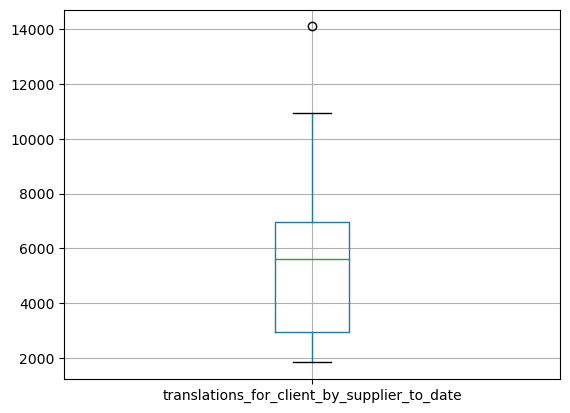

In [82]:
bad_tr_cnt.boxplot()

In [83]:
task_otd.translation_supplier_id.value_counts()[:10].index

Index(['Pantheon_2483', 'Pantheon_818', 'Pantheon_21827', 'Pantheon_179',
       'Pantheon_1357', 'Pantheon_942', 'Pantheon_1109', 'Pantheon_927',
       'Pantheon_6088', 'Pantheon_160'],
      dtype='object')

In [84]:
task_otd.translation_supplier_id.value_counts()[:10].index.isin(bad_translator)

array([ True,  True,  True, False, False,  True, False,  True,  True,
       False])

* We see here that translators can turn deliverables OTD/non-OTD as well
* And between translators that have OTD vs. non-OTD, successful translators have broader IQR, but bad translators do not, but have outlier on the upper end.

<AxesSubplot:>

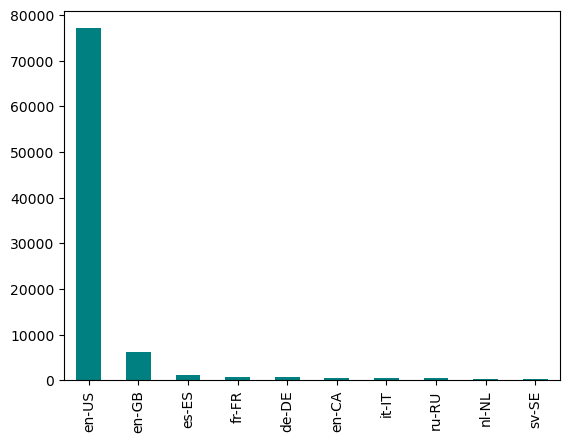

In [85]:
task_otd.source_language_locale_code.value_counts()[:10].plot(kind='bar', color = 'teal')

<AxesSubplot:>

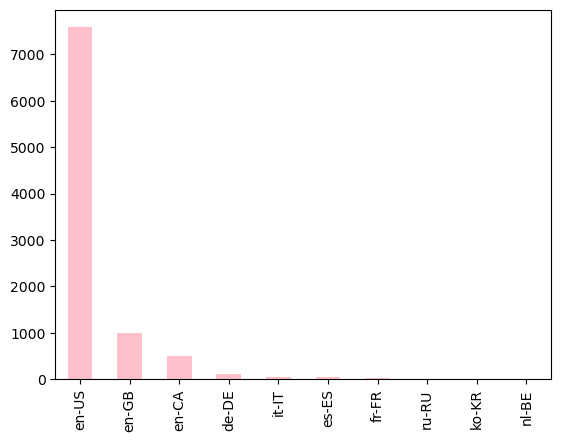

In [86]:
task_non_otd.source_language_locale_code.value_counts()[:10].plot(kind='bar', color = 'pink')

Majority of Source Language is English (US and GB).

In [87]:
translation_task[['source_language_locale_code', 'is_client_deliverable_past_due']].groupby(['source_language_locale_code'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,source_language_locale_code,is_client_deliverable_past_due
53,tgl-PH,1.000000
38,nl-BE,0.647059
4,bs-Latn-BA,0.600000
11,en-CA,0.517350
41,prs-AF,0.500000
22,fr-BE,0.428571
9,de-DE,0.153946
12,en-GB,0.136238
18,es-MX,0.133333
10,el-GR,0.121951


tgl-PH	has perfect positive correlation of non-OTD deliverable!

###  target_language_locale_code

In [88]:
translation_task.groupby(['target_language_locale_code','is_client_deliverable_past_due'])['is_client_deliverable_past_due'].count()

target_language_locale_code  is_client_deliverable_past_due
af-ZA                        False                             133
                             True                               10
am-ET                        False                             125
                             True                                3
ar-AE                        False                             181
                                                              ... 
zh-Hant                      True                              304
zh-SG                        False                              11
                             True                               24
zul-ZA                       False                             153
                             True                                3
Name: is_client_deliverable_past_due, Length: 263, dtype: int64

In [89]:
translation_task[['target_language_locale_code', 'is_client_deliverable_past_due']].groupby(['target_language_locale_code'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,target_language_locale_code,is_client_deliverable_past_due
38,en-SG,1.000000
159,zh-SG,0.685714
35,en-IE,0.600000
129,sq-AL,0.588235
63,fr-XC,0.553086
...,...,...
126,sna-zw,0.000000
127,som-SO,0.000000
128,sot-ZA,0.000000
14,aze-AZ,0.000000


Very interesting! en-SG has high likelihood of non-OTD with perfect correlation!! 

### context_specialty

In [90]:
translation_task[['content_specialty', 'is_client_deliverable_past_due']].groupby(['content_specialty'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,content_specialty,is_client_deliverable_past_due
28,Product,0.315068
9,Financial Statements,0.253731
8,Financial Operations,0.250000
22,Other,0.225583
34,Transfer Pricing_Do not Use,0.200000
29,Product/Service,0.196888
33,Technical Specifications,0.172414
11,Informational,0.146585
15,LS - Medical Devices_DO NOT USE,0.131280
14,LIT: Technical_DO NOT USE,0.130435


If you're a product specialty, Financial related high likelihood of non-OTD. Other is ambiguous.

### translation_supplier_id

In [91]:
translation_task[['translation_supplier_id', 'is_client_deliverable_past_due']].groupby(['translation_supplier_id'], as_index=False).mean().sort_values(by='is_client_deliverable_past_due', ascending=False)

,translation_supplier_id,is_client_deliverable_past_due
898,Pantheon_25830,1.0
966,Pantheon_28022,1.0
198,Pantheon_1432,1.0
567,Pantheon_19681,1.0
682,Pantheon_22157,1.0
...,...,...
663,Pantheon_21975,0.0
662,Pantheon_2195,0.0
661,Pantheon_21948,0.0
660,Pantheon_21941,0.0


There are a bunch of linquists who have delivered non-OTD...We can verify this with our heatmap.

### Correlations

* change target variable to OTD with 1 = OTD and 0 = non-OTD



In [92]:
translation_task['is_client_deliverable_past_due'] = translation_task['is_client_deliverable_past_due'].astype(int)
translation_task['OTD'] = translation_task['is_client_deliverable_past_due'].replace({0:1, 1:0})

translation_task.drop(columns=['is_client_deliverable_past_due'], inplace=True)

In [93]:
categorical_features=identify_nominal_columns(translation_task)
categorical_features

['source_language_locale_code',
 'target_language_locale_code',
 'content_specialty',
 'translation_supplier_id']

In [94]:
translation_task2 = translation_task[['translations_for_client_by_supplier_to_date',
 'average_duration_offer_sent_to_task_claimed_hours',
 'average_duration_task_claimed_to_task_started_days',
 'source_language_locale_code',
 'target_language_locale_code',
 'content_specialty',
 'translation_supplier_id',
 'OTD']]

### Holistic View of Correlation/Association
#### Caveat: 
For Numerical - Nominal Comparisons, Correlation Ratio is used. Hence, this is a different metric and not used for comparisons between numeric and binary column. So this will be over written with Point Biserial Correlation Coefficient. Refer to below for numeric-numeric correlations, numeric-nominal (non-binary) associations, nominal-nominal associations

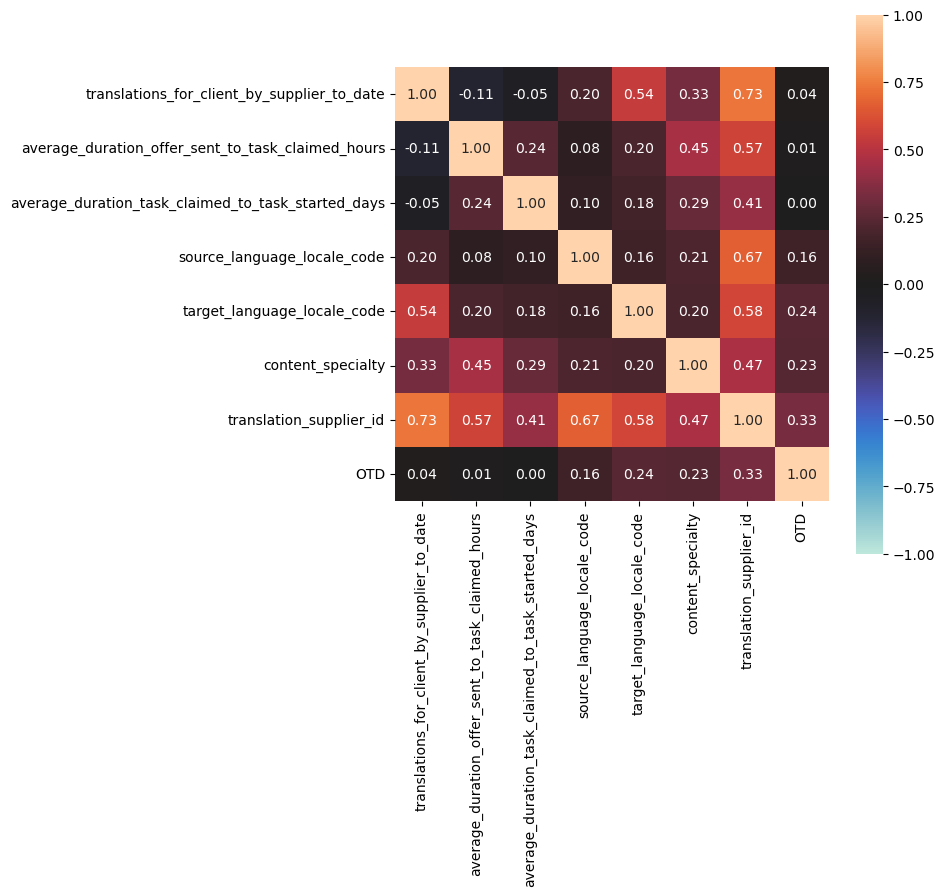

{'corr':                                                     translations_for_client_by_supplier_to_date  \
 translations_for_client_by_supplier_to_date                                            1.000000   
 average_duration_offer_sent_to_task_claimed_hours                                     -0.113204   
 average_duration_task_claimed_to_task_started_days                                    -0.050900   
 source_language_locale_code                                                            0.201961   
 target_language_locale_code                                                            0.539789   
 content_specialty                                                                      0.325396   
 translation_supplier_id                                                                0.727445   
 OTD                                                                                    0.035761   
 
                                                     average_duration_offer_sent_to_task_c

In [95]:
complete_correlation= associations(translation_task2, nominal_columns=['source_language_locale_code', 'target_language_locale_code','content_specialty','translation_supplier_id', 'OTD'], numerical_columns=['translations_for_client_by_supplier_to_date','average_duration_offer_sent_to_task_claimed_hours','average_duration_task_claimed_to_task_started_days','translations_for_client_by_supplier_to_date'], figsize=(7,7))
complete_correlation

(For dython heatmap: Ignoring numeric to nominal associations):

Most noteworthy correlations:
# Pearson's R (testing numerical-numerical correlations) Effect Size:

* Small: 0.1 - 0.3 / -0.1 to -0.3
* Medium: 0.3 - 0.5 / -0.3 to -0.5
* Large: >= 0.5 / <= -0.5

____________________________

# Cramer's V (testing nominal-nominal associations) Effect Size:

* 0 means no association and 1 is full association
* Small: 0.10 – < 0.30
* Medium: 0.30 – < 0.50
* Large: ≥ 0.50
_____________________
### Numerical - Numerical:
* task claim time - task start time --0.24 -small

### Nominal- Nominal:
* source_language_locale_code - translation_supplier_id -- .67 --large -just saying that some translators have specialties
* target_language_locale_code - translation_supplier_id -- .58 --large -just saying that some translators have specialties
* content specialty - translation_supplier_id -- .47 --medium
* content specialty - source_language_locale_code -- .21 --small
* content speciality - target_language_locale_code -- .20 --small
* OTD - translation_supplier_id -- .33 --medium --this is significant
* OTD - content specialty -- .23 --small
* OTD - target language locale code --.245 --small

### Numerical - Nominal (Binary) Association using Point Biserial Correlation Coefficient

In [96]:
translation_task2 = translation_task2.fillna(0)

In [97]:
translation_num_columns = ['translations_for_client_by_supplier_to_date',
 'average_duration_offer_sent_to_task_claimed_hours',
 'average_duration_task_claimed_to_task_started_days']

In [98]:
def point_bi(column): 
    df = pd.DataFrame({'continuous_column': translation_task2[column],
                   'binary_column': translation_task2['OTD']})

    # split the continuous column by the binary column
    group1 = df.loc[df['binary_column'] == 0, 'continuous_column']
    group2 = df.loc[df['binary_column'] == 1, 'continuous_column']

    # calculate the point-biserial correlation coefficient and p-value
    corr, p = pointbiserialr(df['binary_column'], df['continuous_column'])

    # print the result
    print(column, 'x OTD Point-biserial correlation coefficient:', corr)

for c in translation_num_columns:
    point_bi(c)

translations_for_client_by_supplier_to_date x OTD Point-biserial correlation coefficient: 0.03576097041956976
average_duration_offer_sent_to_task_claimed_hours x OTD Point-biserial correlation coefficient: -0.014568835867893992
average_duration_task_claimed_to_task_started_days x OTD Point-biserial correlation coefficient: -0.001541533389893631


Reminder: Point-Biserial correlation coefficient Effect Size:

* Small: 0.1 - 0.3 / -0.1 to -0.3
* Medium: 0.3 - 0.5 / -0.3 to -0.5
* Large: >= 0.5 / <= -0.5

Looks like all numeric columns have low association with OTD.

### Now let's see if the request/deliverable/task time journeys, which ones could be a clog (not really taking into account quote time)

In [99]:
# Remember: Sparse amount of data
requests2['average_duration_request_received_to_quoted_business_days'].describe() 

count    99697.000000
mean         0.036361
std          1.708064
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        166.223669
Name: average_duration_request_received_to_quoted_business_days, dtype: float64

In [100]:
translation_task2[['average_duration_offer_sent_to_task_claimed_hours', 'average_duration_task_claimed_to_task_started_days']].describe()

,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_days
count,99697.000000,99697.000000
mean,14.123296,1.384070
std,35.143520,2.431521
min,0.000000,0.000000
25%,0.470000,0.106389
50%,3.324444,0.591134
75%,12.060556,1.653009
max,974.623611,75.913426


In [101]:
deliverables3[['lateness_of_client_deliverable_days']].describe()

,lateness_of_client_deliverable_days
count,99697.000000
mean,0.977494
std,5.914076
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,289.416480


Looks like the biggest blocker in task/deliverable journey is actually starting it. However, this data coule be split my those that made OTD as well as target language.

# Now that we know that highest contributors to OTD is project manager and translation supplier ID
1. let's take a little closer look at top 10 contributors to OTD/non-OTD 
2. what are there average metrics readings for OTD success
3. what are there average metrics readings for OTD failure

In [102]:
# good/bad based on top/bottom 10 of each group (project manager/translator)
# Let's go back to good/bad PM, good/bad translator var's and get descriptive stat's on them. And see if there are differences

data2 = data.loc[data['is_client_deliverable_past_due'] != 'Unspecified']
# remember there are project managers that are in the good and bad groups
data_good_pm = data2.loc[data2['project_manager_id'].isin(good_pm)]
data_bad_pm = data2.loc[data2['project_manager_id'].isin(bad_pm)]

In [103]:
#at request level since project managers handle requests which have deliverables
data_good_pm[['average_duration_request_received_to_quoted_business_seconds', 'requests_managed_simultaneously_by_project_manager']].describe()

,average_duration_request_received_to_quoted_business_seconds,requests_managed_simultaneously_by_project_manager
count,0.0,36887.000000
mean,NaN,449.189335
std,NaN,1166.557996
min,NaN,1.000000
25%,NaN,53.000000
50%,NaN,83.000000
75%,NaN,192.000000
max,NaN,5759.000000


In [104]:
data_bad_pm[['average_duration_request_received_to_quoted_business_seconds', 'requests_managed_simultaneously_by_project_manager']].describe()

,average_duration_request_received_to_quoted_business_seconds,requests_managed_simultaneously_by_project_manager
count,0.0,22870.000000
mean,NaN,661.069392
std,NaN,1439.954519
min,NaN,1.000000
25%,NaN,54.000000
50%,NaN,83.000000
75%,NaN,220.000000
max,NaN,5759.000000


<AxesSubplot:>

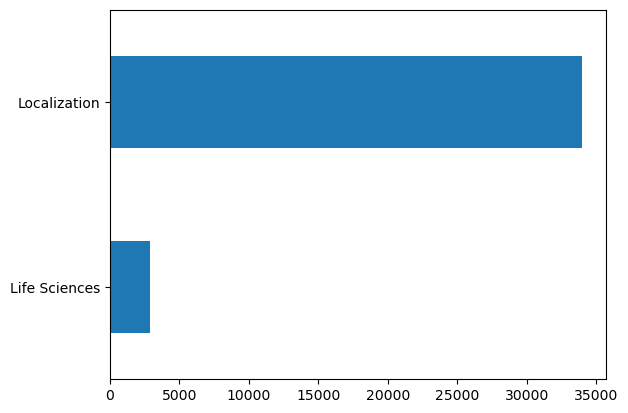

In [105]:
data_good_pm.service_line.value_counts().sort_values().plot(kind = 'barh')

In [106]:
data_bad_pm.service_line.value_counts().sort_values()

Legal & Financial Services       20
Localization                  22850
Name: service_line, dtype: int64

### Observations:
* PM's that are not delivering on time (in the bottom 12) have on average a lot more requests on their plate and are distinctly coming from Legal & Financial Services part of the org.
* PM's delivering on time are distinctly coming from Life Sciences.

In [107]:
data_good_trans = data2.loc[data2['translation_supplier_id'].isin(good_translator)]
data_bad_trans = data2.loc[data2['translation_supplier_id'].isin(bad_translator)]

In [108]:
data_good_trans[['total_tasks','words', 'average_duration_offer_sent_to_task_claimed_seconds',
 'average_duration_task_claimed_to_task_started_seconds',
 'translations_for_client_by_supplier_to_date']].describe()

,total_tasks,words,average_duration_offer_sent_to_task_claimed_seconds,average_duration_task_claimed_to_task_started_seconds,translations_for_client_by_supplier_to_date
count,21188.000000,21188.000000,1.779500e+04,2.036900e+04,21188.000000
mean,2.423494,615.929064,3.076965e+04,1.208127e+05,4430.821078
std,1.293174,3028.746802,7.576852e+04,2.110363e+05,4316.769855
min,1.000000,0.000000,5.000000e+00,0.000000e+00,1.000000
25%,2.000000,16.000000,1.299000e+03,1.001500e+04,1021.000000
50%,2.000000,69.000000,6.788000e+03,5.275300e+04,2674.000000
75%,3.000000,312.000000,2.642200e+04,1.435990e+05,6720.000000
max,20.000000,122365.000000,2.855379e+06,4.012837e+06,14089.000000


In [109]:
data_bad_trans[['total_tasks','words', 'average_duration_offer_sent_to_task_claimed_seconds',
 'average_duration_task_claimed_to_task_started_seconds',
 'translations_for_client_by_supplier_to_date']].describe()

,total_tasks,words,average_duration_offer_sent_to_task_claimed_seconds,average_duration_task_claimed_to_task_started_seconds,translations_for_client_by_supplier_to_date
count,18344.000000,18344.000000,1.390800e+04,1.719500e+04,18344.000000
mean,2.359954,571.466583,3.171811e+04,1.258406e+05,3946.301406
std,1.419451,2989.990011,7.269873e+04,2.324557e+05,4003.046392
min,1.000000,0.000000,1.900000e+01,0.000000e+00,1.000000
25%,2.000000,16.000000,1.497000e+03,6.432500e+03,973.000000
50%,2.000000,64.000000,8.501500e+03,4.943400e+04,2386.000000
75%,3.000000,286.000000,3.043825e+04,1.432355e+05,6006.000000
max,50.000000,122365.000000,2.855379e+06,4.020264e+06,14089.000000


<AxesSubplot:>

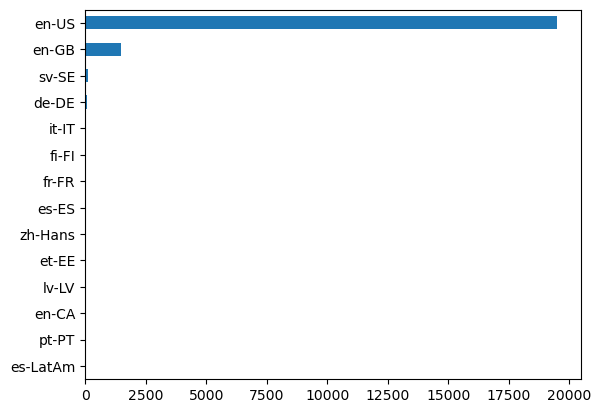

In [110]:
data_good_trans['source_language_locale_code'].value_counts().sort_values().plot(kind = 'barh') 

<AxesSubplot:>

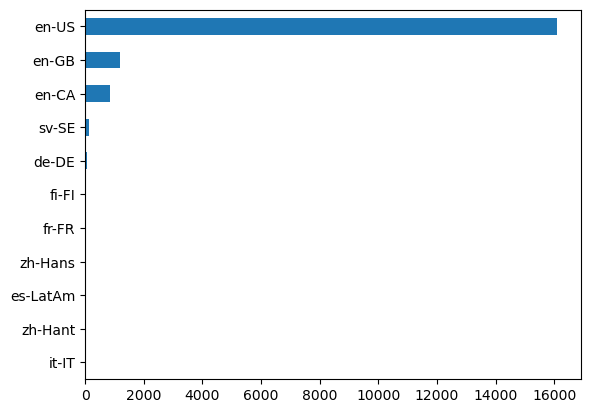

In [111]:
data_bad_trans['source_language_locale_code'].value_counts().sort_values().plot(kind = 'barh')

In [112]:
data_good_trans['target_language_locale_code'].value_counts(), data_bad_trans['target_language_locale_code'].value_counts()

(es-ES         2977
 fr-FR         2523
 sv-SE         1781
 nb-NO         1533
 ru-RU         1510
 da-DK         1439
 it-IT         1329
 de-DE         1032
 fi-FI          835
 zh-HK          760
 pt-BR          749
 es-MX          742
 zh-Hans        732
 fr-XC          405
 es-Intl        350
 uk-UA          339
 ca-ES          269
 es-US          262
 lv-LV          222
 lt-LT          193
 zh-Hant        193
 es-LatAm       192
 et-EE          171
 az-Latn-AZ     144
 en-GB          129
 kk-KZ          126
 eu-ES           40
 gl-ES           34
 ka-GE           28
 it-CH           25
 sk-SK           25
 fr-BE           18
 es-CL           14
 fr-CH           14
 ja-JP           12
 es-AR           12
 en-US            8
 fr-MA            4
 hu-HU            3
 fr-CA            3
 es-CO            2
 aze-AZ           2
 nl-NL            2
 nl-BE            2
 fr-LU            1
 pl-PL            1
 bg-BG            1
 Name: target_language_locale_code, dtype: int64,
 es-ES    

In [113]:
data_bad_trans['target_language_locale_code'].value_counts(), data_bad_trans['target_language_locale_code'].value_counts()

(es-ES         1699
 fr-FR         1695
 sv-SE         1546
 ru-RU         1509
 de-DE         1481
 nb-NO         1330
 da-DK         1158
 zh-Hant       1066
 fr-CA         1030
 zh-HK          760
 pt-BR          748
 es-MX          742
 zh-Hans        732
 fi-FI          623
 fr-XC          405
 uk-UA          337
 es-Intl        325
 es-US          262
 es-LatAm       181
 az-Latn-AZ     144
 ca-ES          136
 kk-KZ          125
 en-GB          123
 de-CH           81
 ka-GE           28
 fr-BE           18
 es-CL           14
 fr-CH           14
 es-AR           12
 en-US            6
 fr-MA            4
 es-CO            2
 de-AT            2
 aze-AZ           2
 nl-BE            2
 fr-LU            1
 bg-BG            1
 Name: target_language_locale_code, dtype: int64,
 es-ES         1699
 fr-FR         1695
 sv-SE         1546
 ru-RU         1509
 de-DE         1481
 nb-NO         1330
 da-DK         1158
 zh-Hant       1066
 fr-CA         1030
 zh-HK          760
 pt-BR    

<AxesSubplot:>

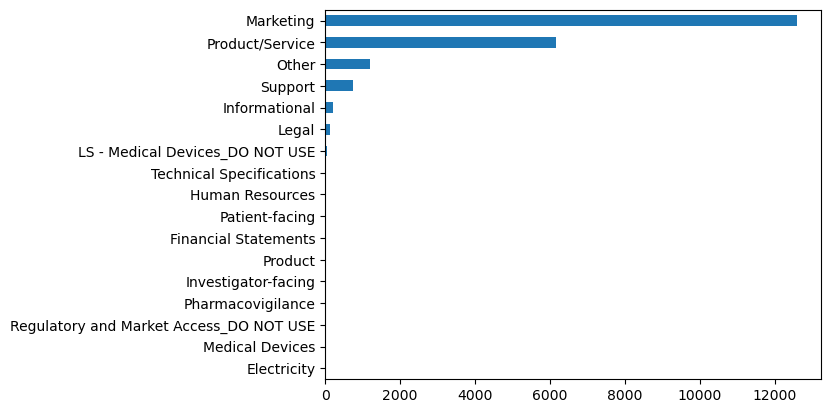

In [114]:
data_good_trans['content_specialty'].value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

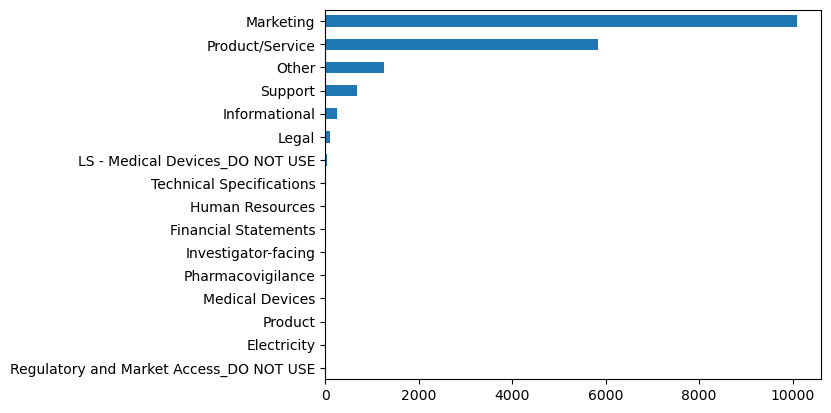

In [115]:
data_bad_trans['content_specialty'].value_counts().sort_values().plot(kind = 'barh')

### Observations:

* good translators have had more translators done and translations with greater volume of words (more experience)
* bad translators are failing at en-CA source lang